In [1]:
import mlflow
import pandas as pd
from pathlib import Path

from lib.config import AppConfig

mlflow.set_tracking_uri(AppConfig().mlflow_tracking_uri)

experiments_by_oxide = {
    'SiO2': '123',
    'TiO2': '125', 
    'Al2O3': '131',
    'FeO': '130', 
    'MgO': '126',
    'CaO': '128',
    'Na2O': '127',
    'K2O': '129',
}

n_splits = 4
runs_file_path = "/home/christian/projects/p9/baseline/optuna_runs.csv"

In [2]:
def get_runs_across_oxides():
    oxide_runs = {}
    for oxide, experiment_id in experiments_by_oxide.items():
        runs = mlflow.search_runs(experiment_ids=[experiment_id])
        oxide_runs[oxide] = runs
    return oxide_runs


def get_full_runs_df():
    if Path(runs_file_path).exists():
        return pd.read_csv(runs_file_path)

    oxide_runs = get_runs_across_oxides()
    runs = pd.concat(oxide_runs.values(), ignore_index=True)
    runs.to_csv(runs_file_path)

    return runs

runs = get_full_runs_df()

In [3]:
failed_runs = runs[runs['status'] == 'FAILED']
runs = runs[runs['status'] != 'FAILED']

print(f"Failed runs: {failed_runs.shape[0]}")
print(f"Successful runs: {runs.shape[0]}")

Failed runs: 247
Successful runs: 7793


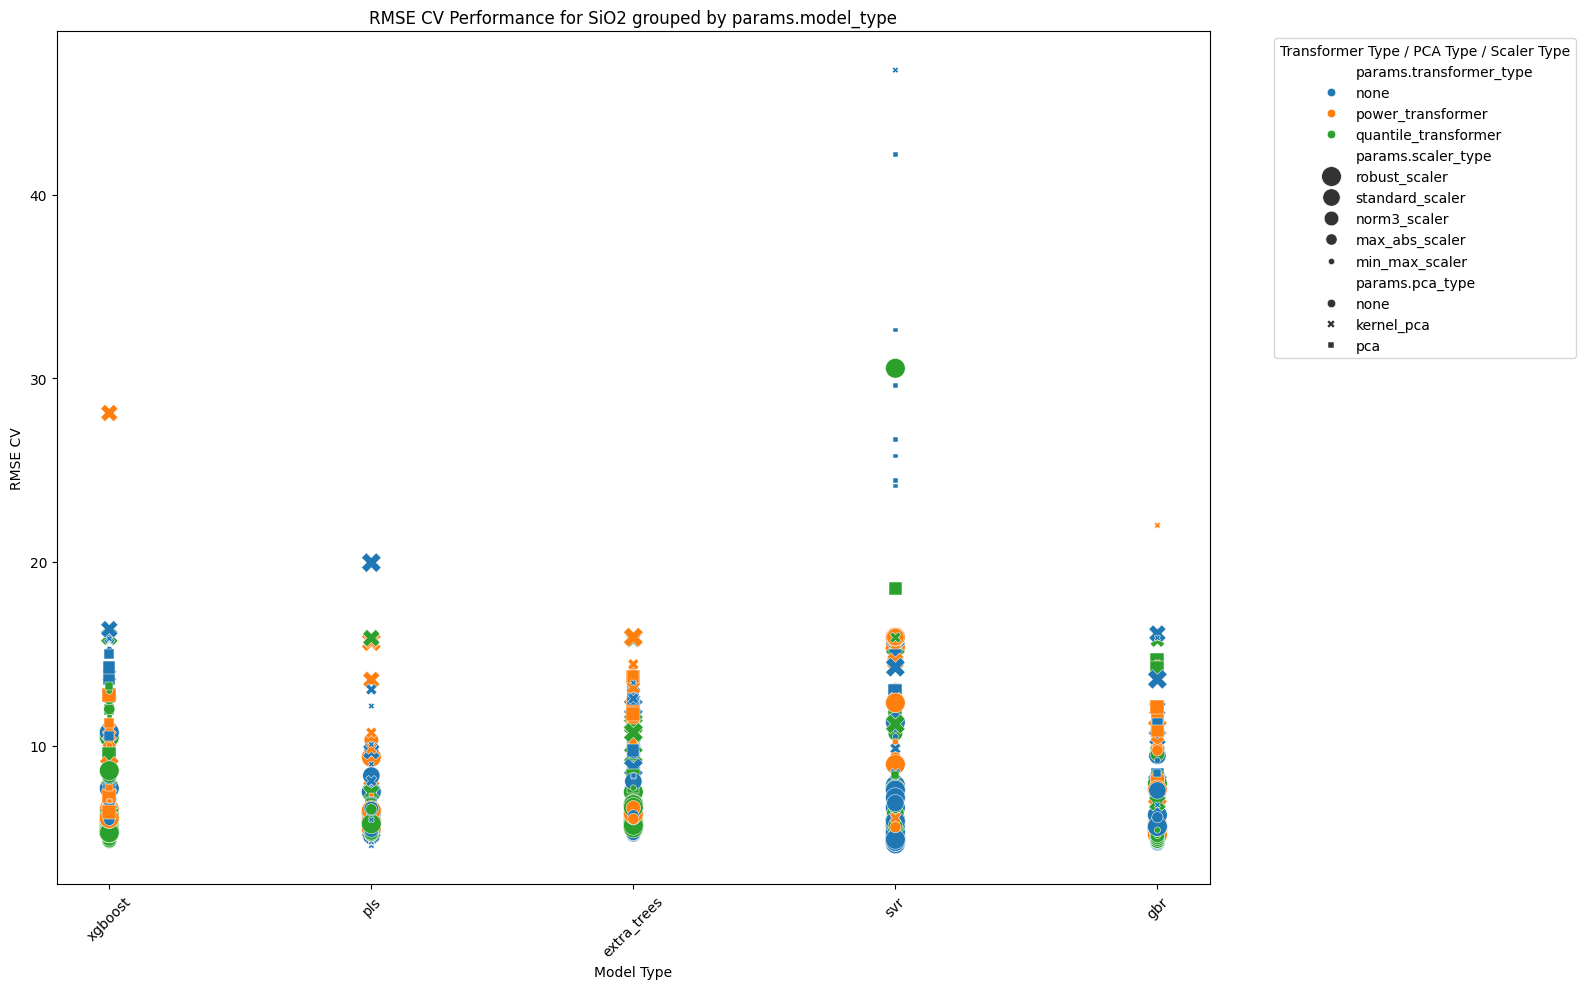

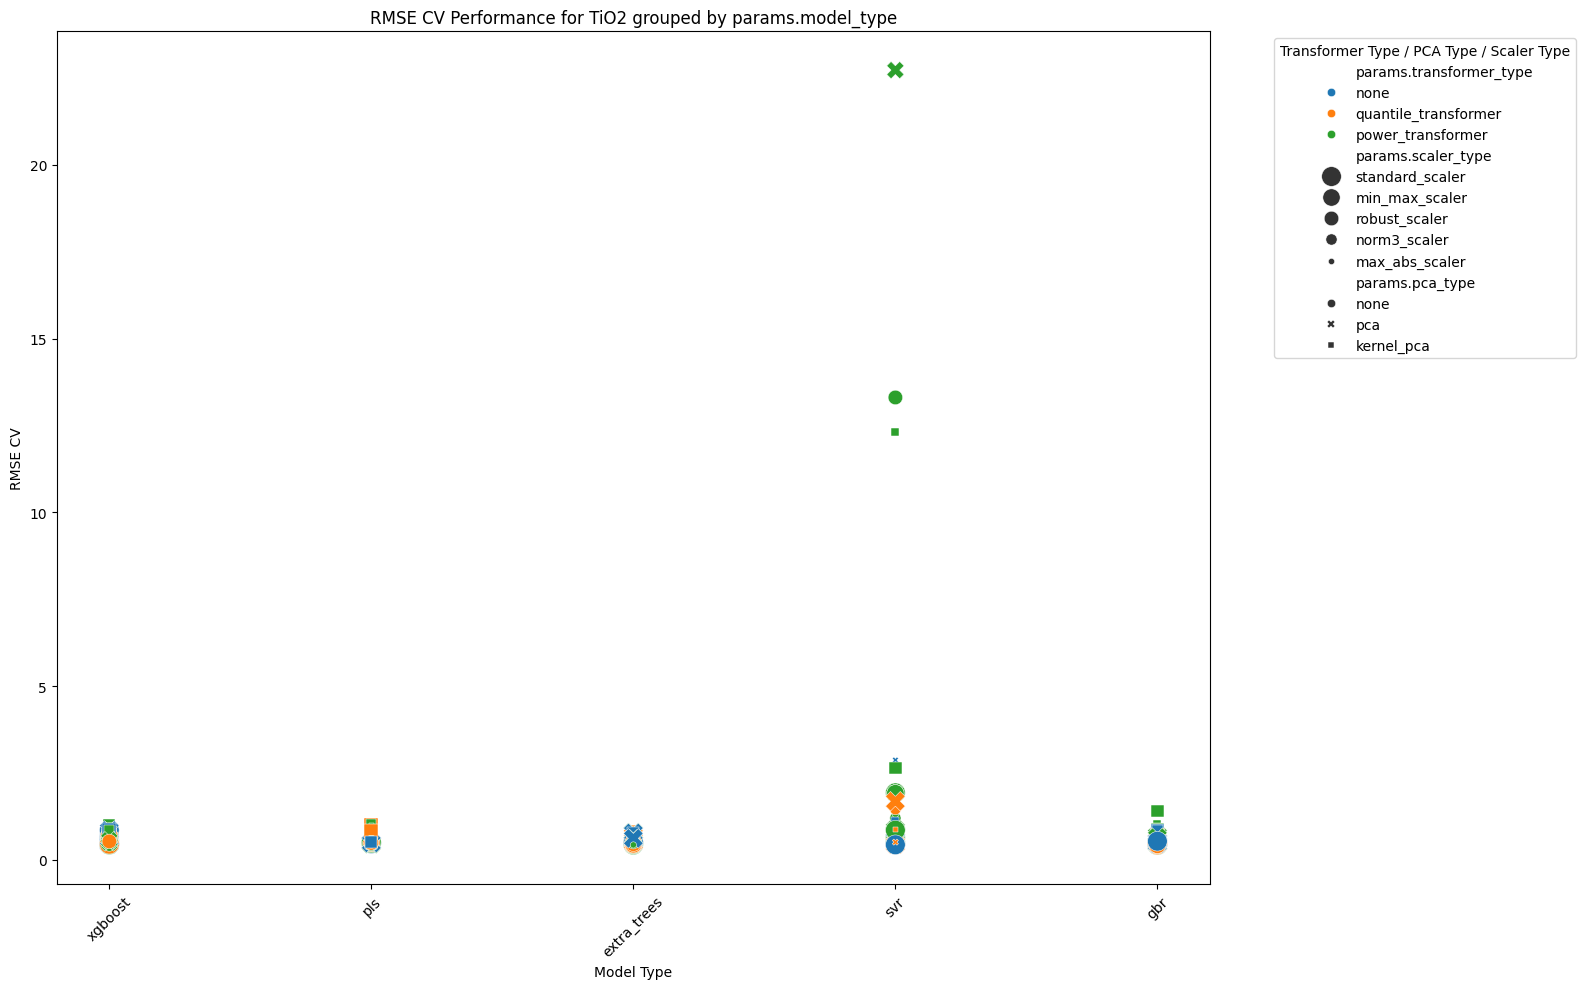

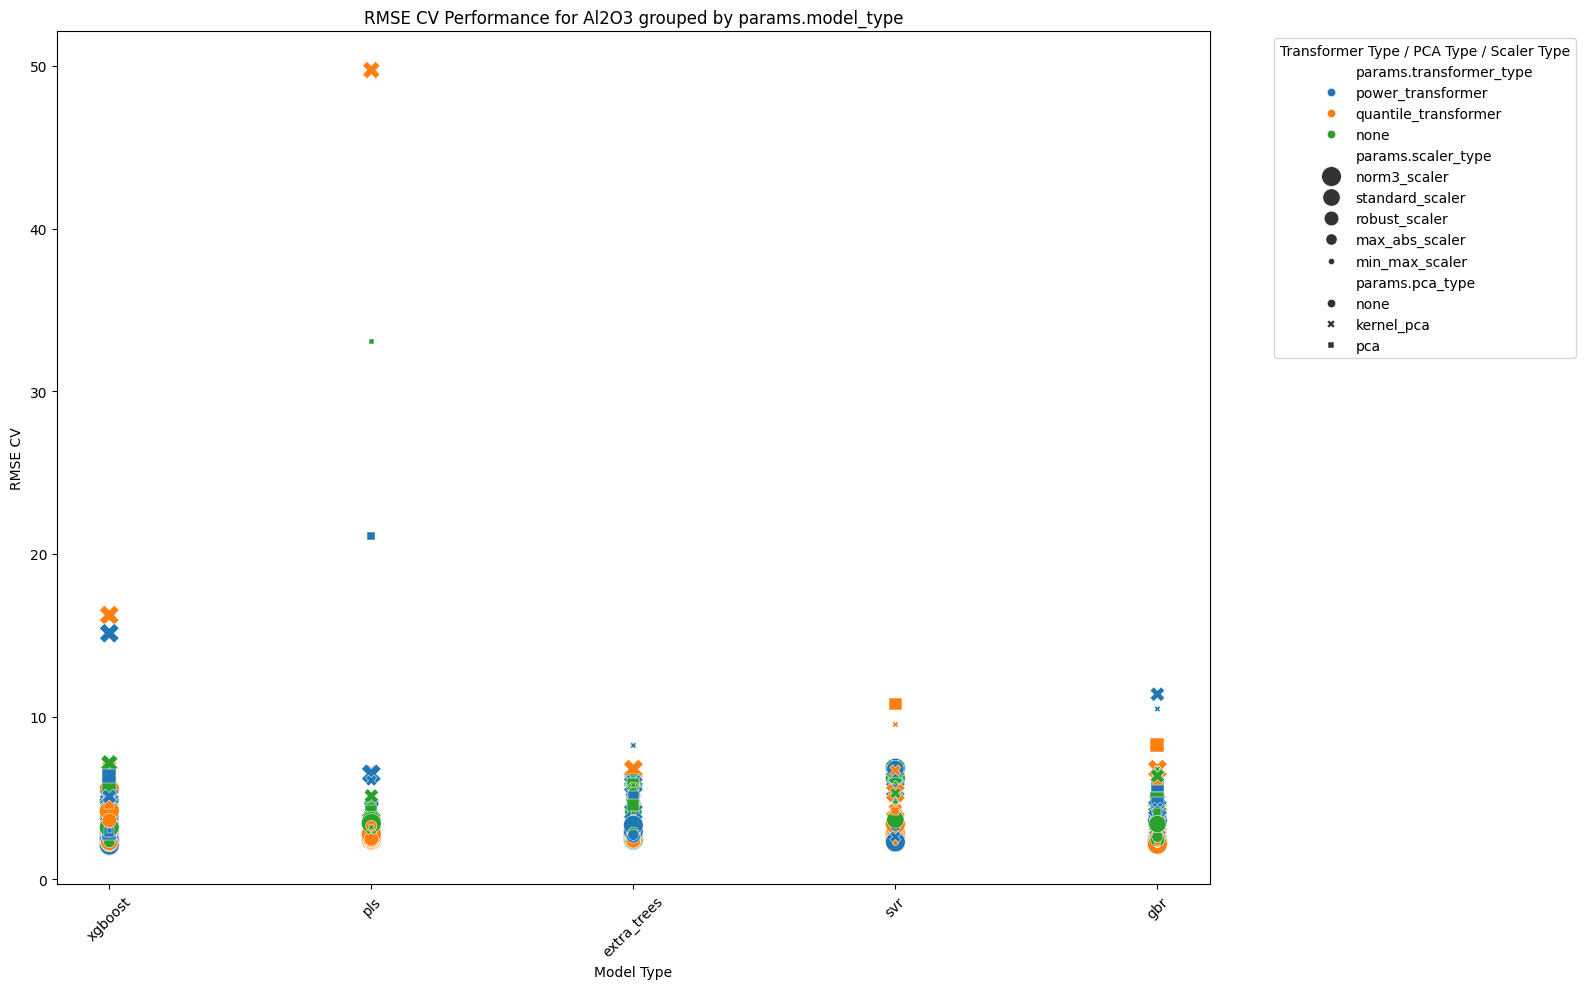

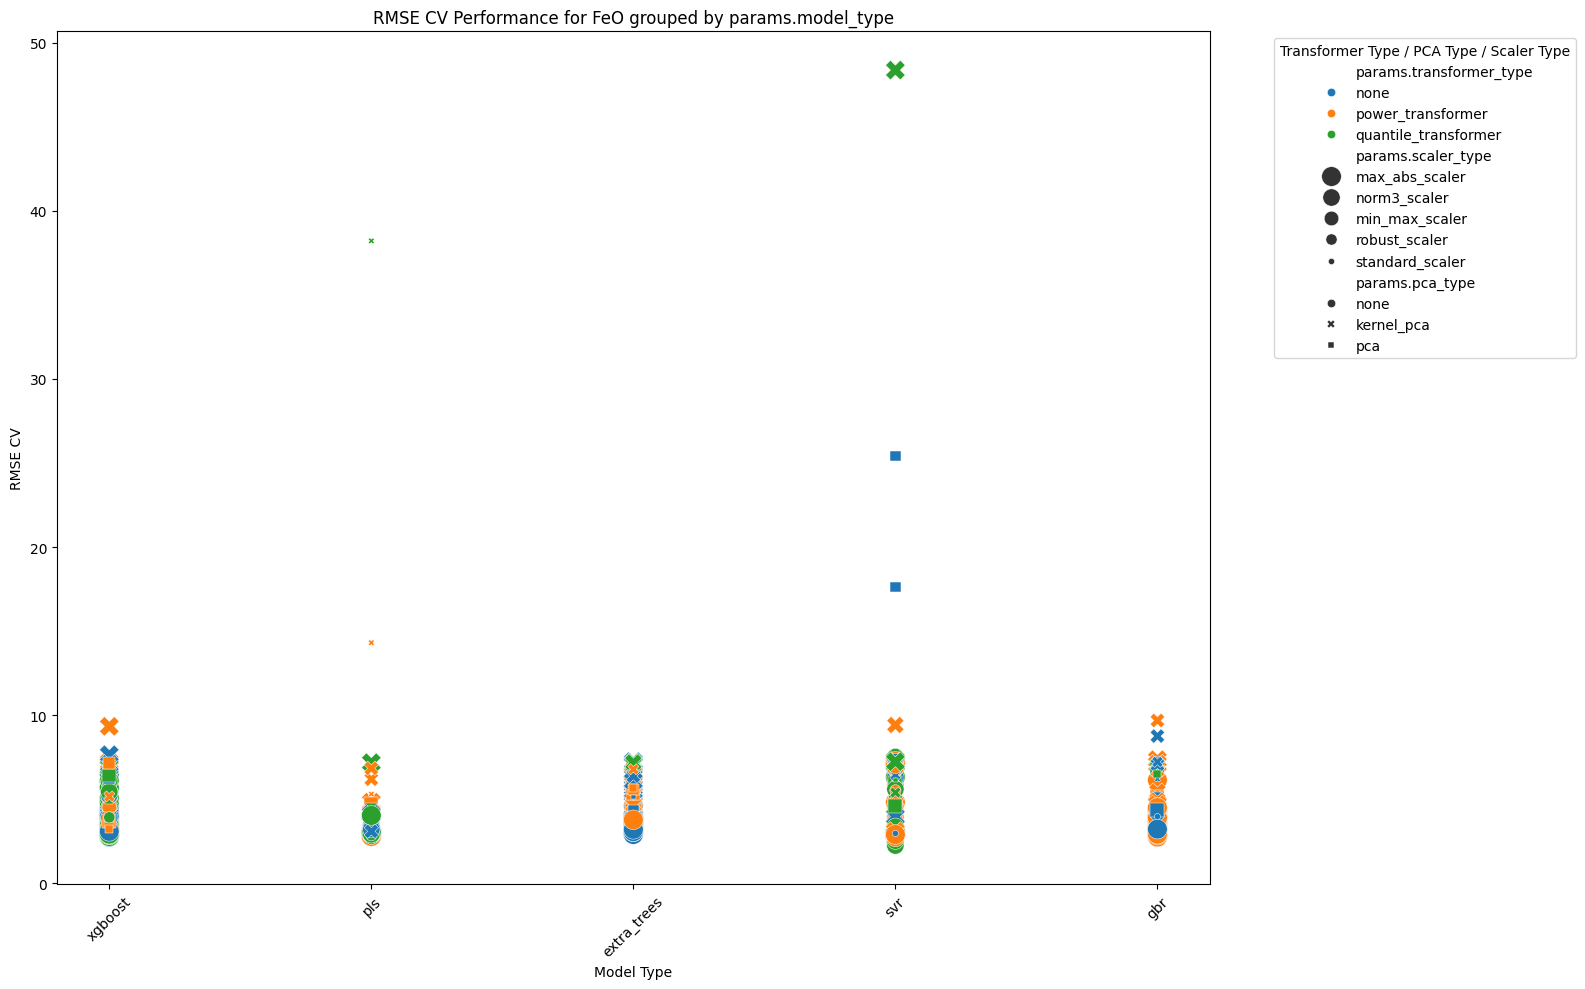

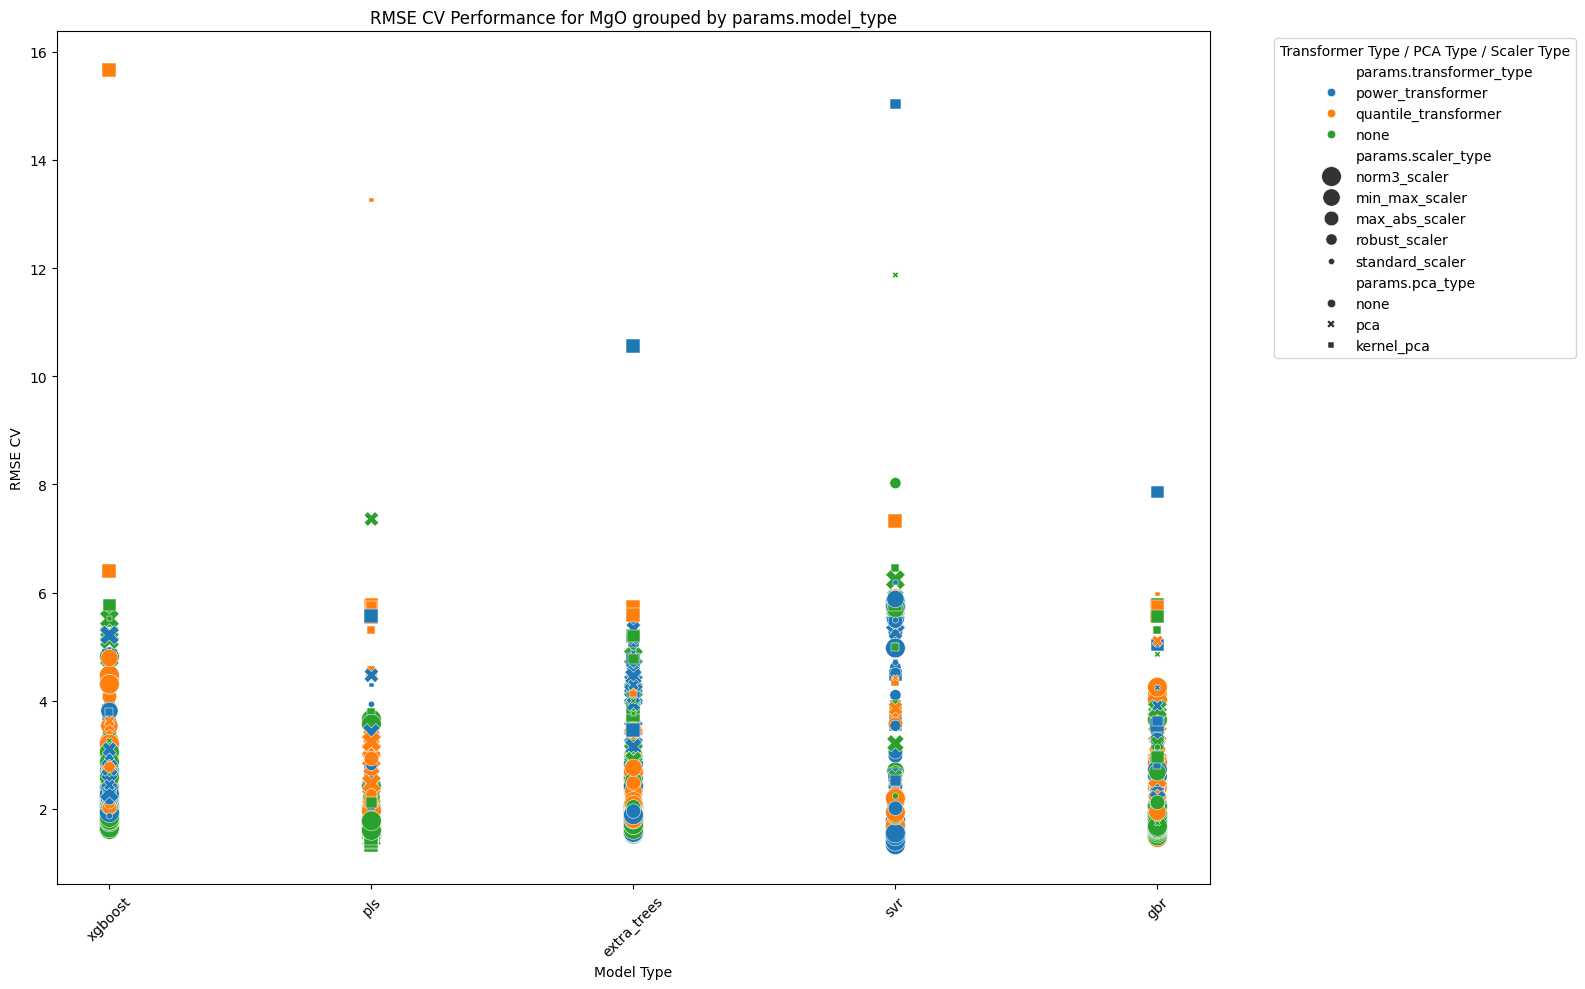

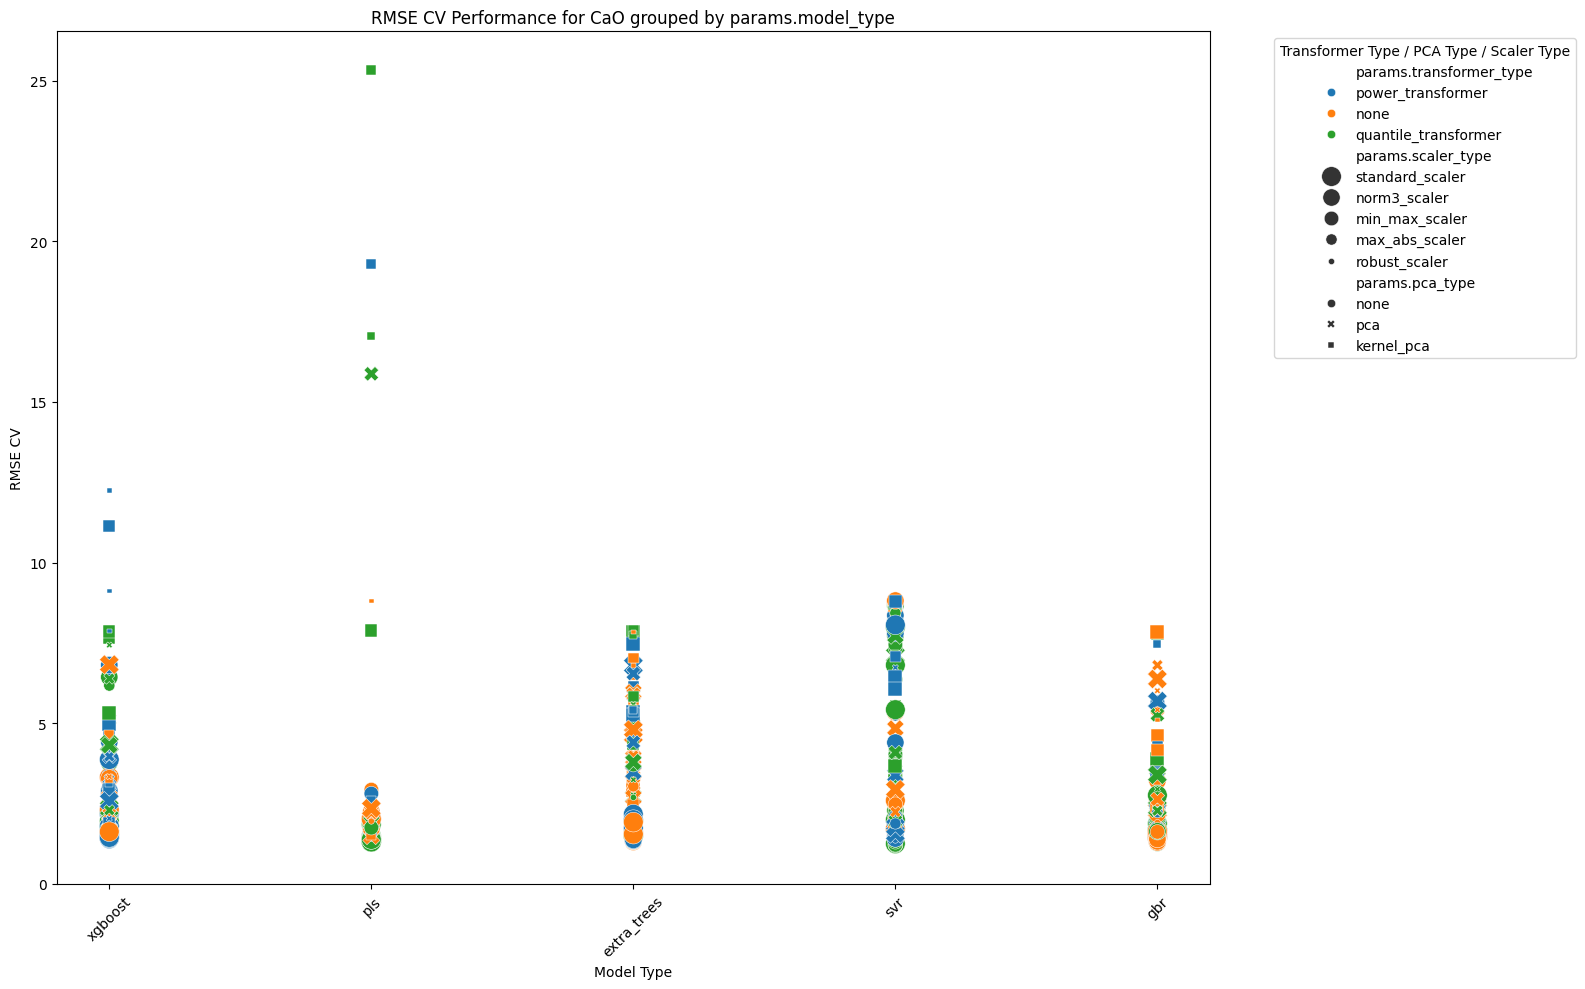

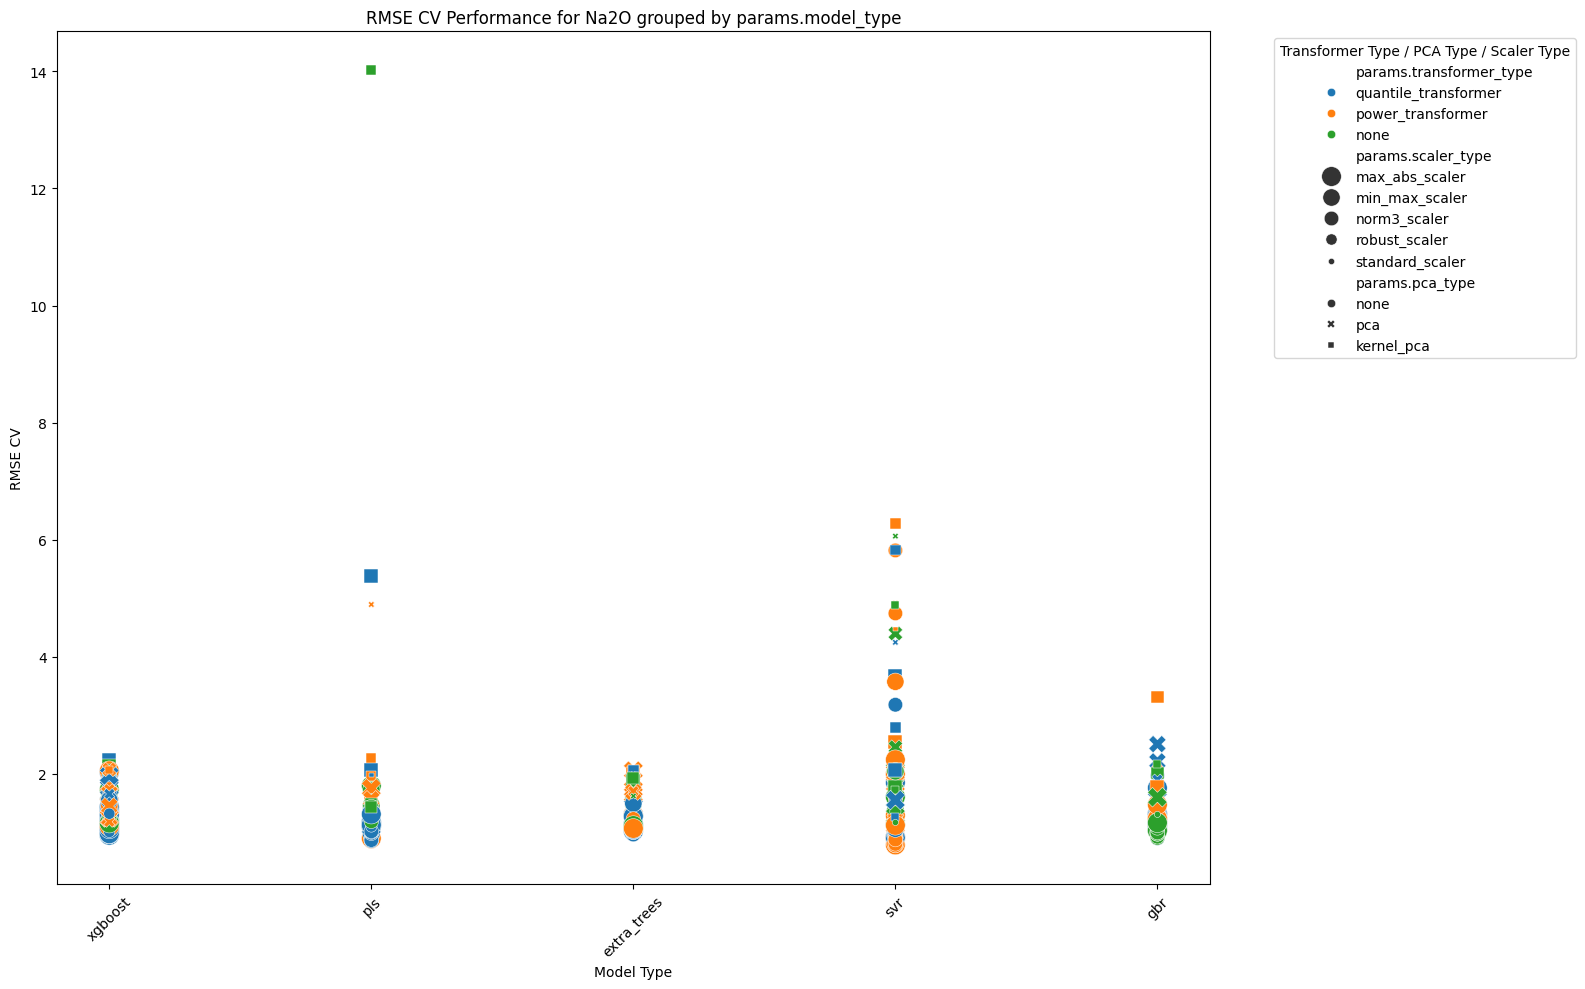

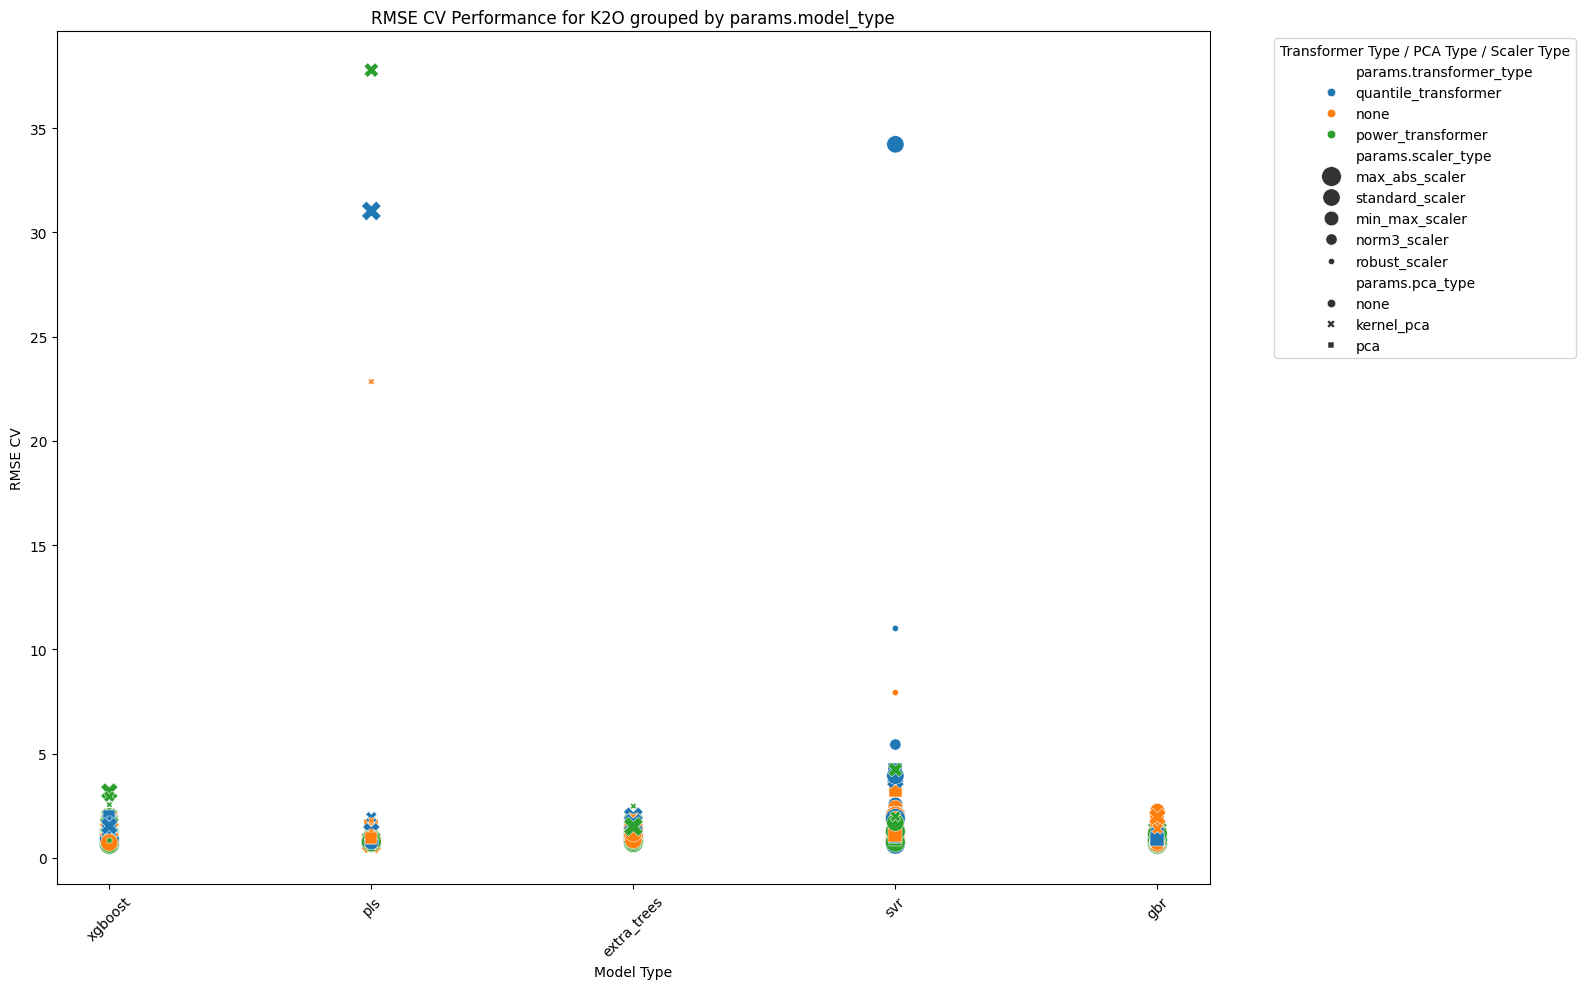

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the necessary columns are present
required_columns = ['params.oxide', 'metrics.rmse_cv', 'params.model_type', 'params.transformer_type', 'params.pca_type', 'params.scaler_type']
for col in required_columns:
    if (col not in runs.columns):
        raise ValueError(f"Missing required column: {col}")

# Filter out trials with rmse_cv > 50
runs_filtered = runs[runs['metrics.rmse_cv'] <= 50]

# Function to create visualizations based on a specified column
def create_visualizations(group_by_col):
    oxides = runs_filtered['params.oxide'].unique()
    for oxide in oxides:
        oxide_data = runs_filtered[runs_filtered['params.oxide'] == oxide]
        
        plt.figure(figsize=(16, 10))
        sns.scatterplot(data=oxide_data, x=group_by_col, y='metrics.rmse_cv', hue='params.transformer_type', style='params.pca_type', size='params.scaler_type', sizes=(20, 200))
        plt.title(f'RMSE CV Performance for {oxide} grouped by {group_by_col}')
        plt.xlabel(group_by_col.replace('params.', '').replace('_', ' ').title())
        plt.ylabel('RMSE CV')
        plt.legend(title='Transformer Type / PCA Type / Scaler Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage: create visualizations grouped by 'params.model_type'
create_visualizations('params.model_type')


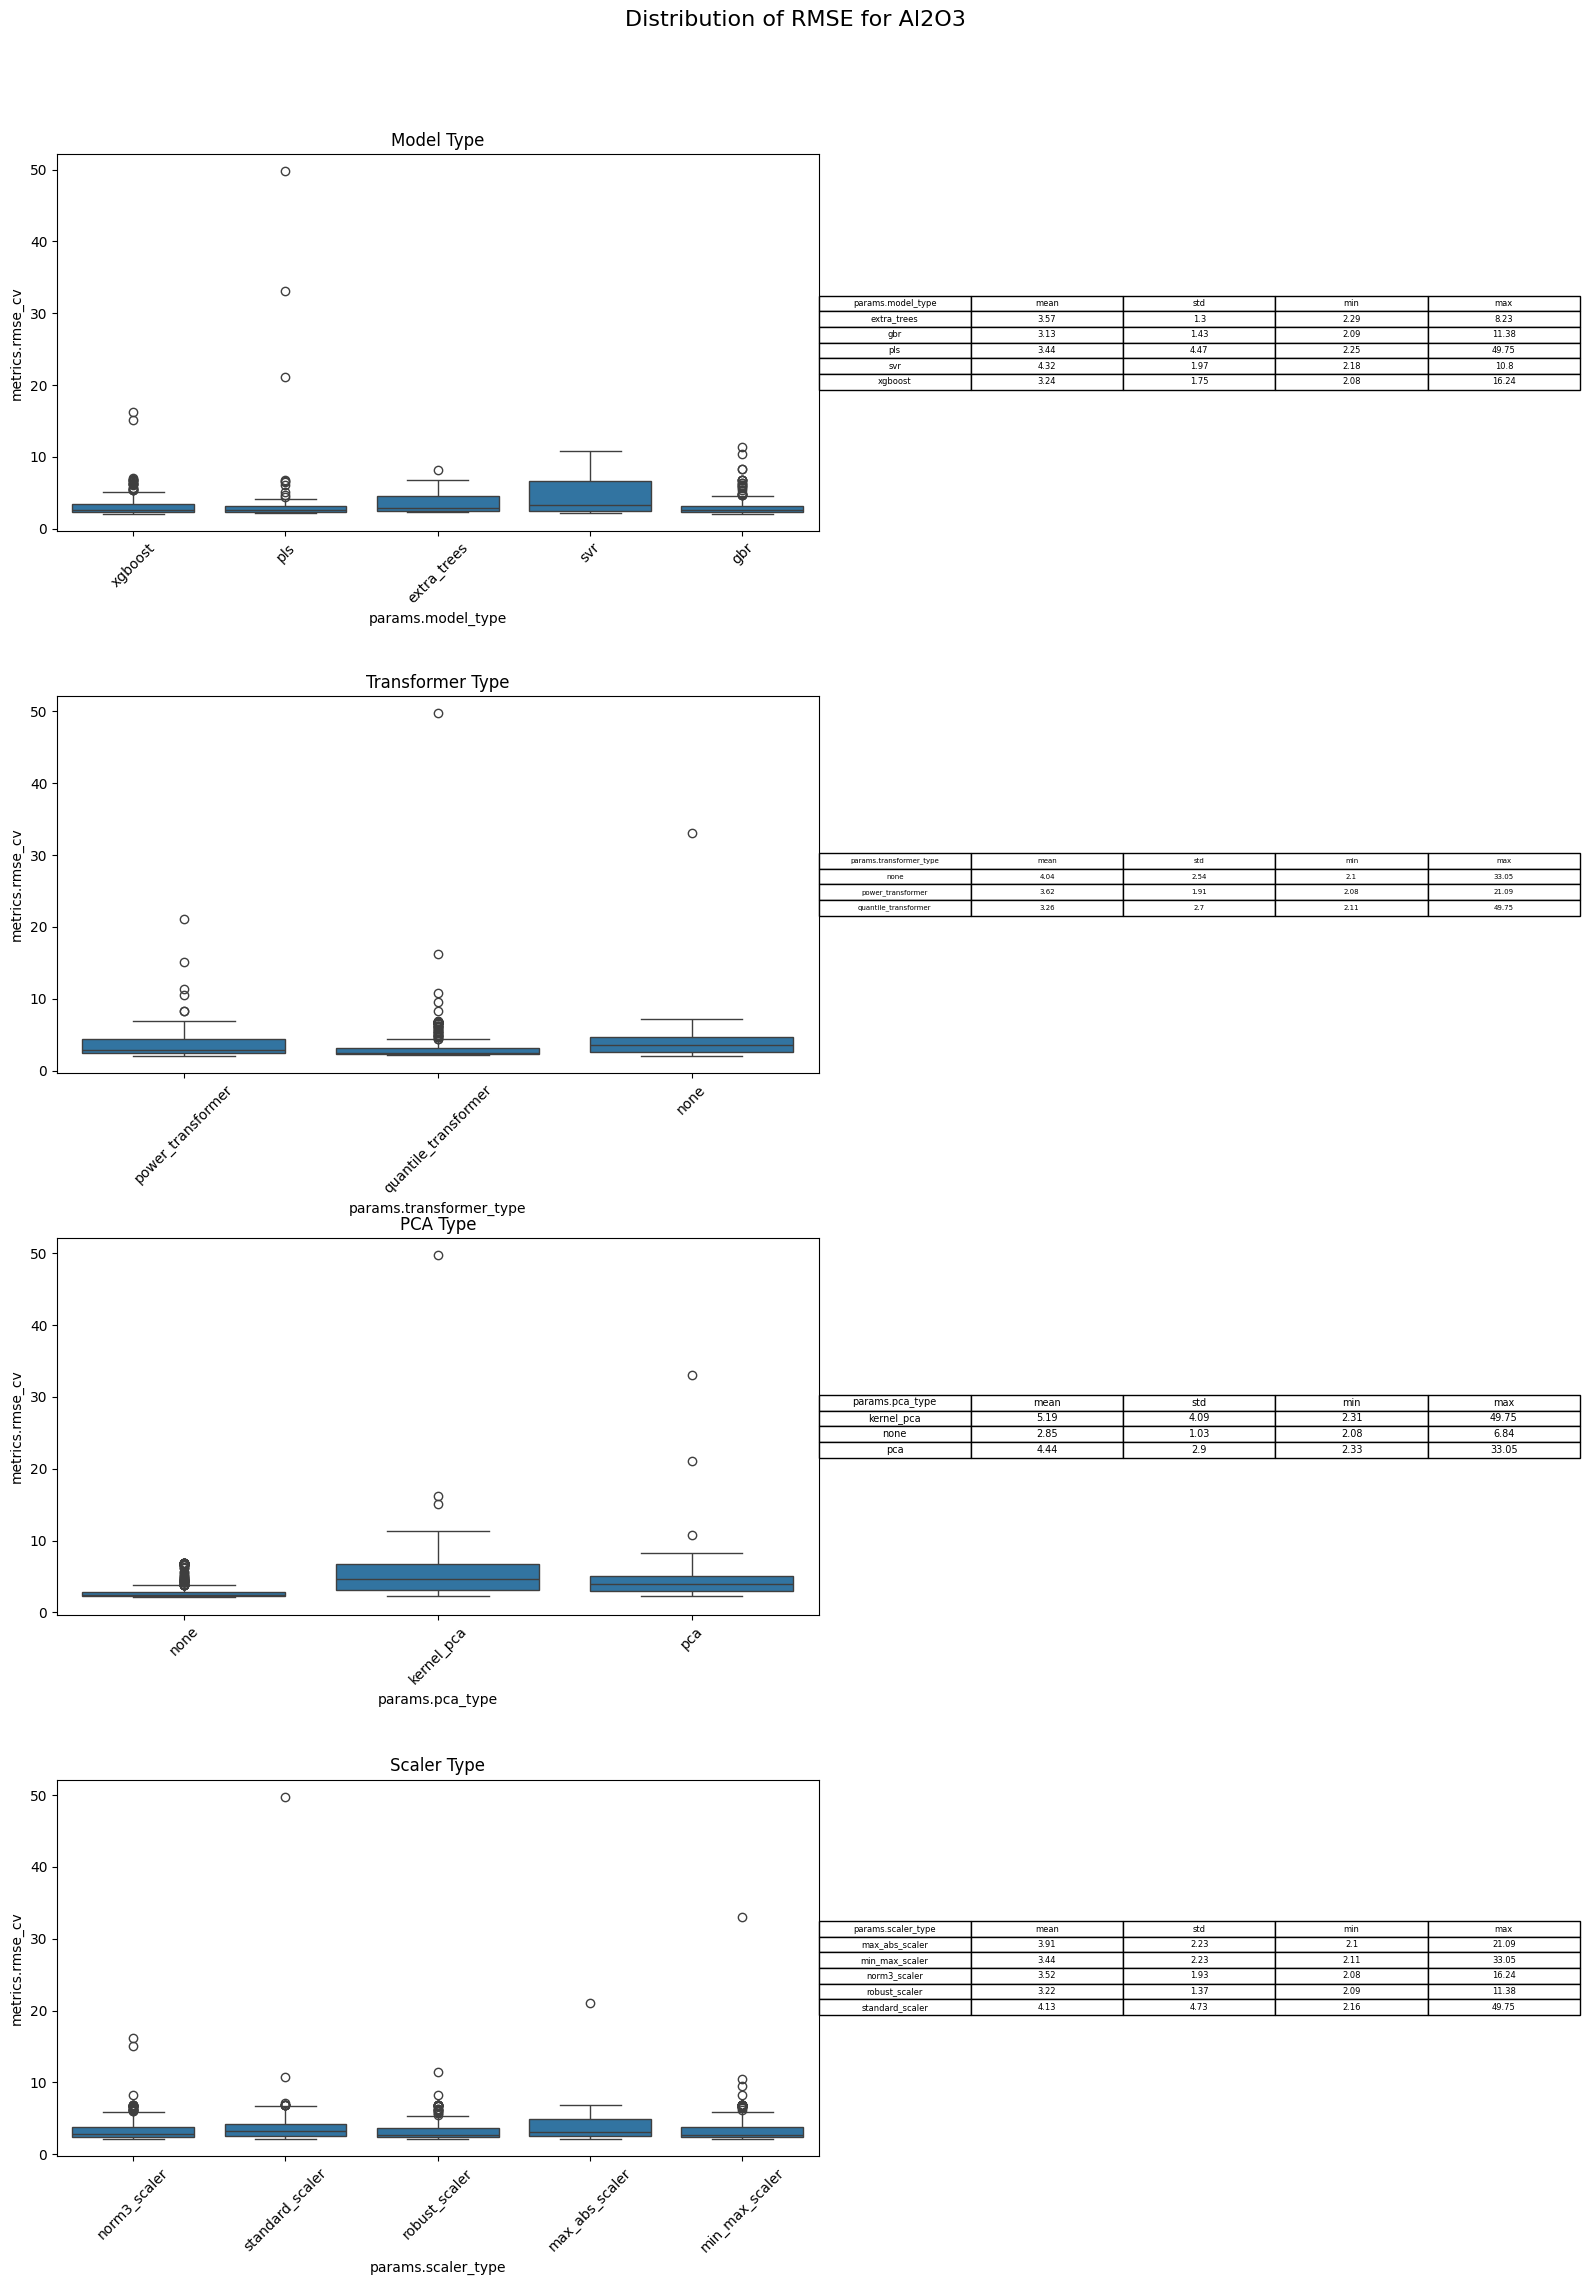

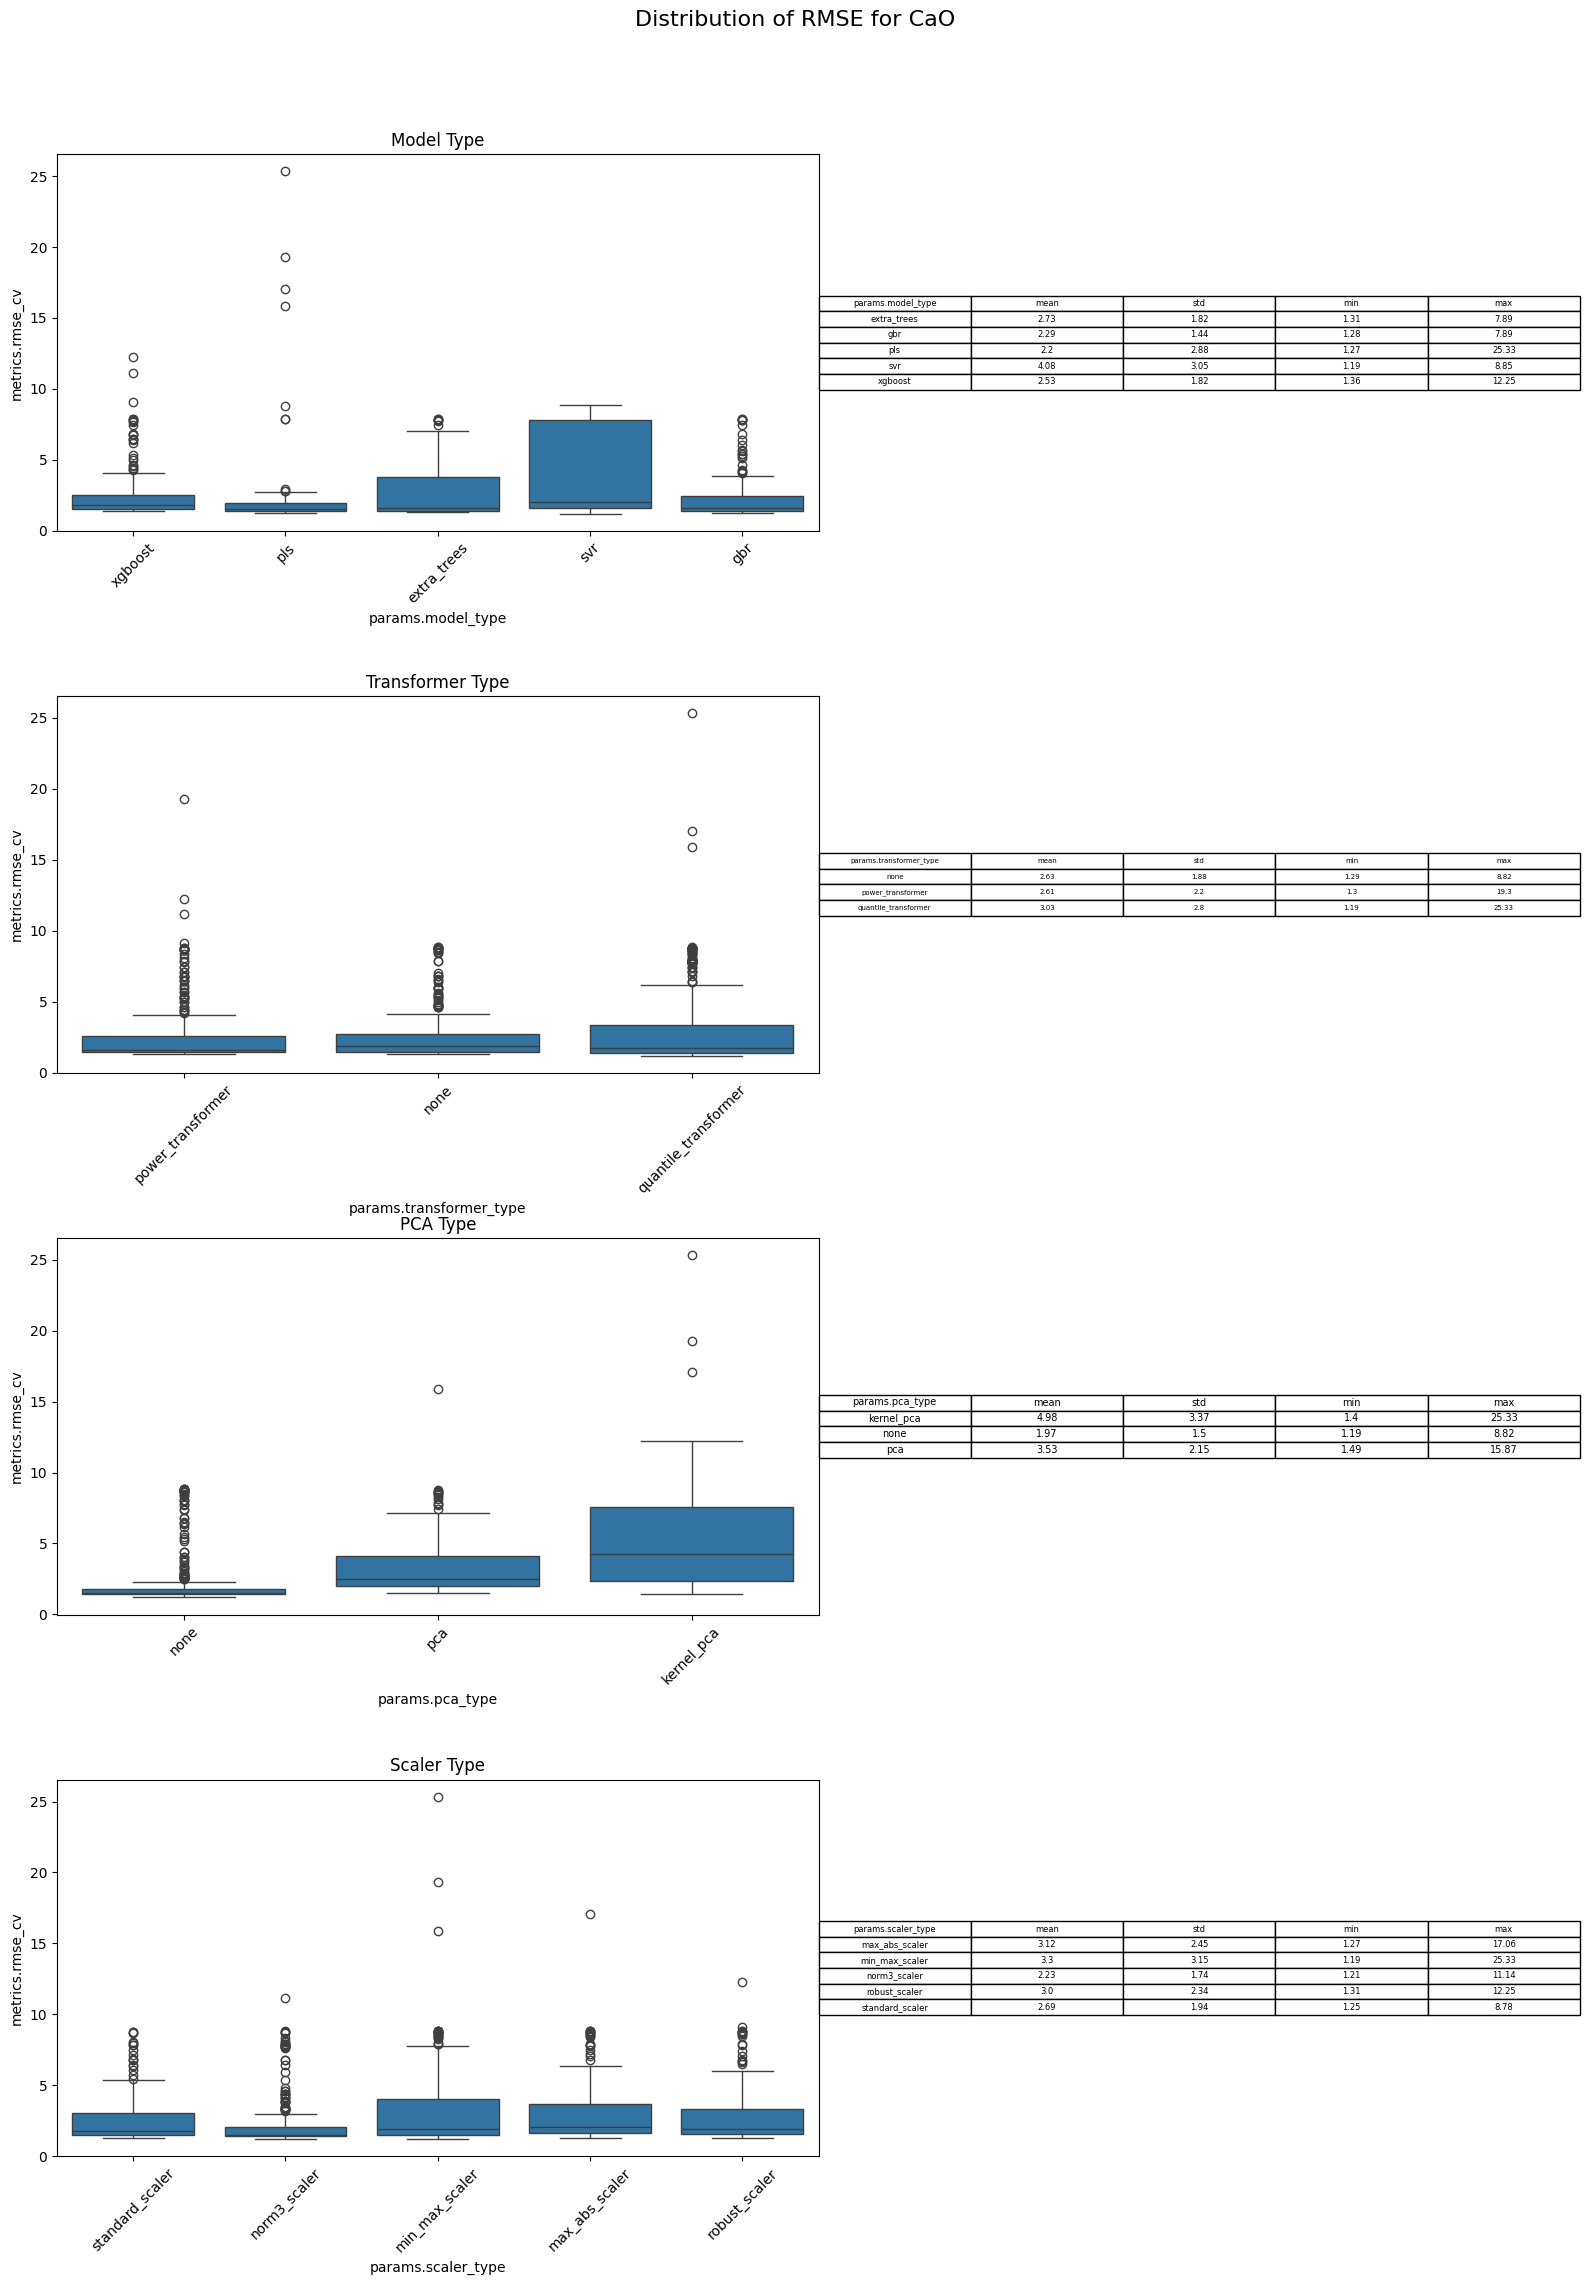

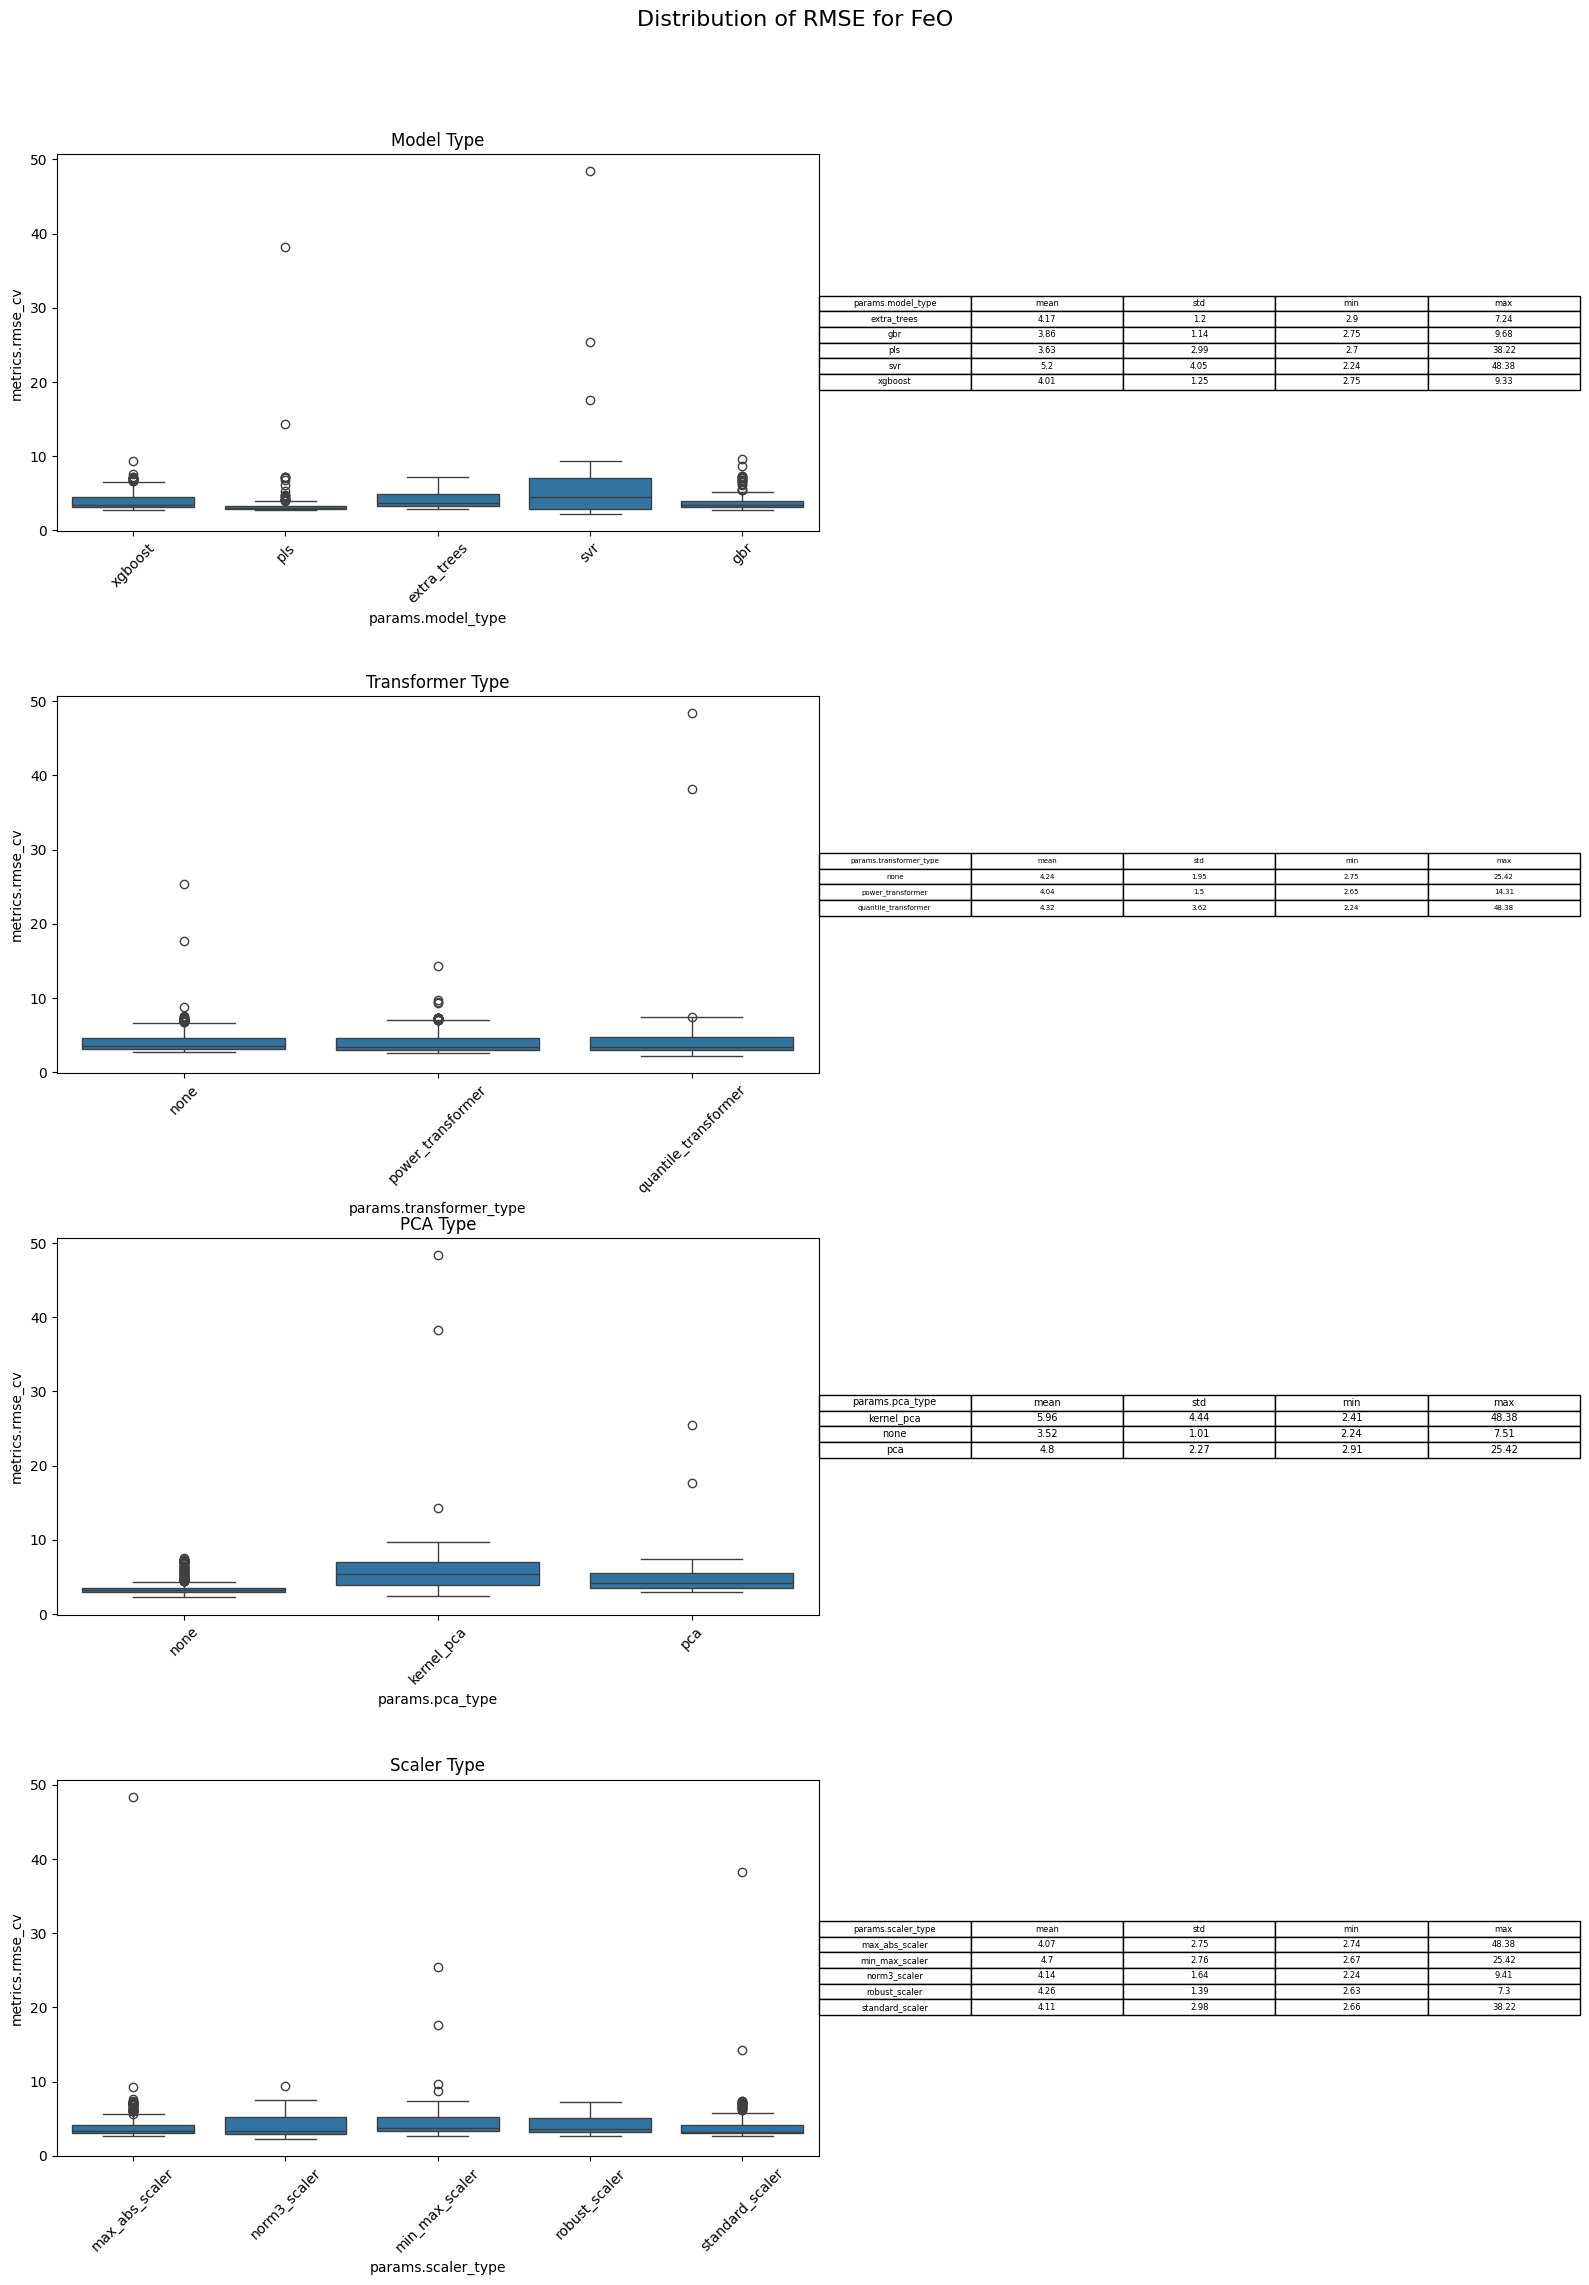

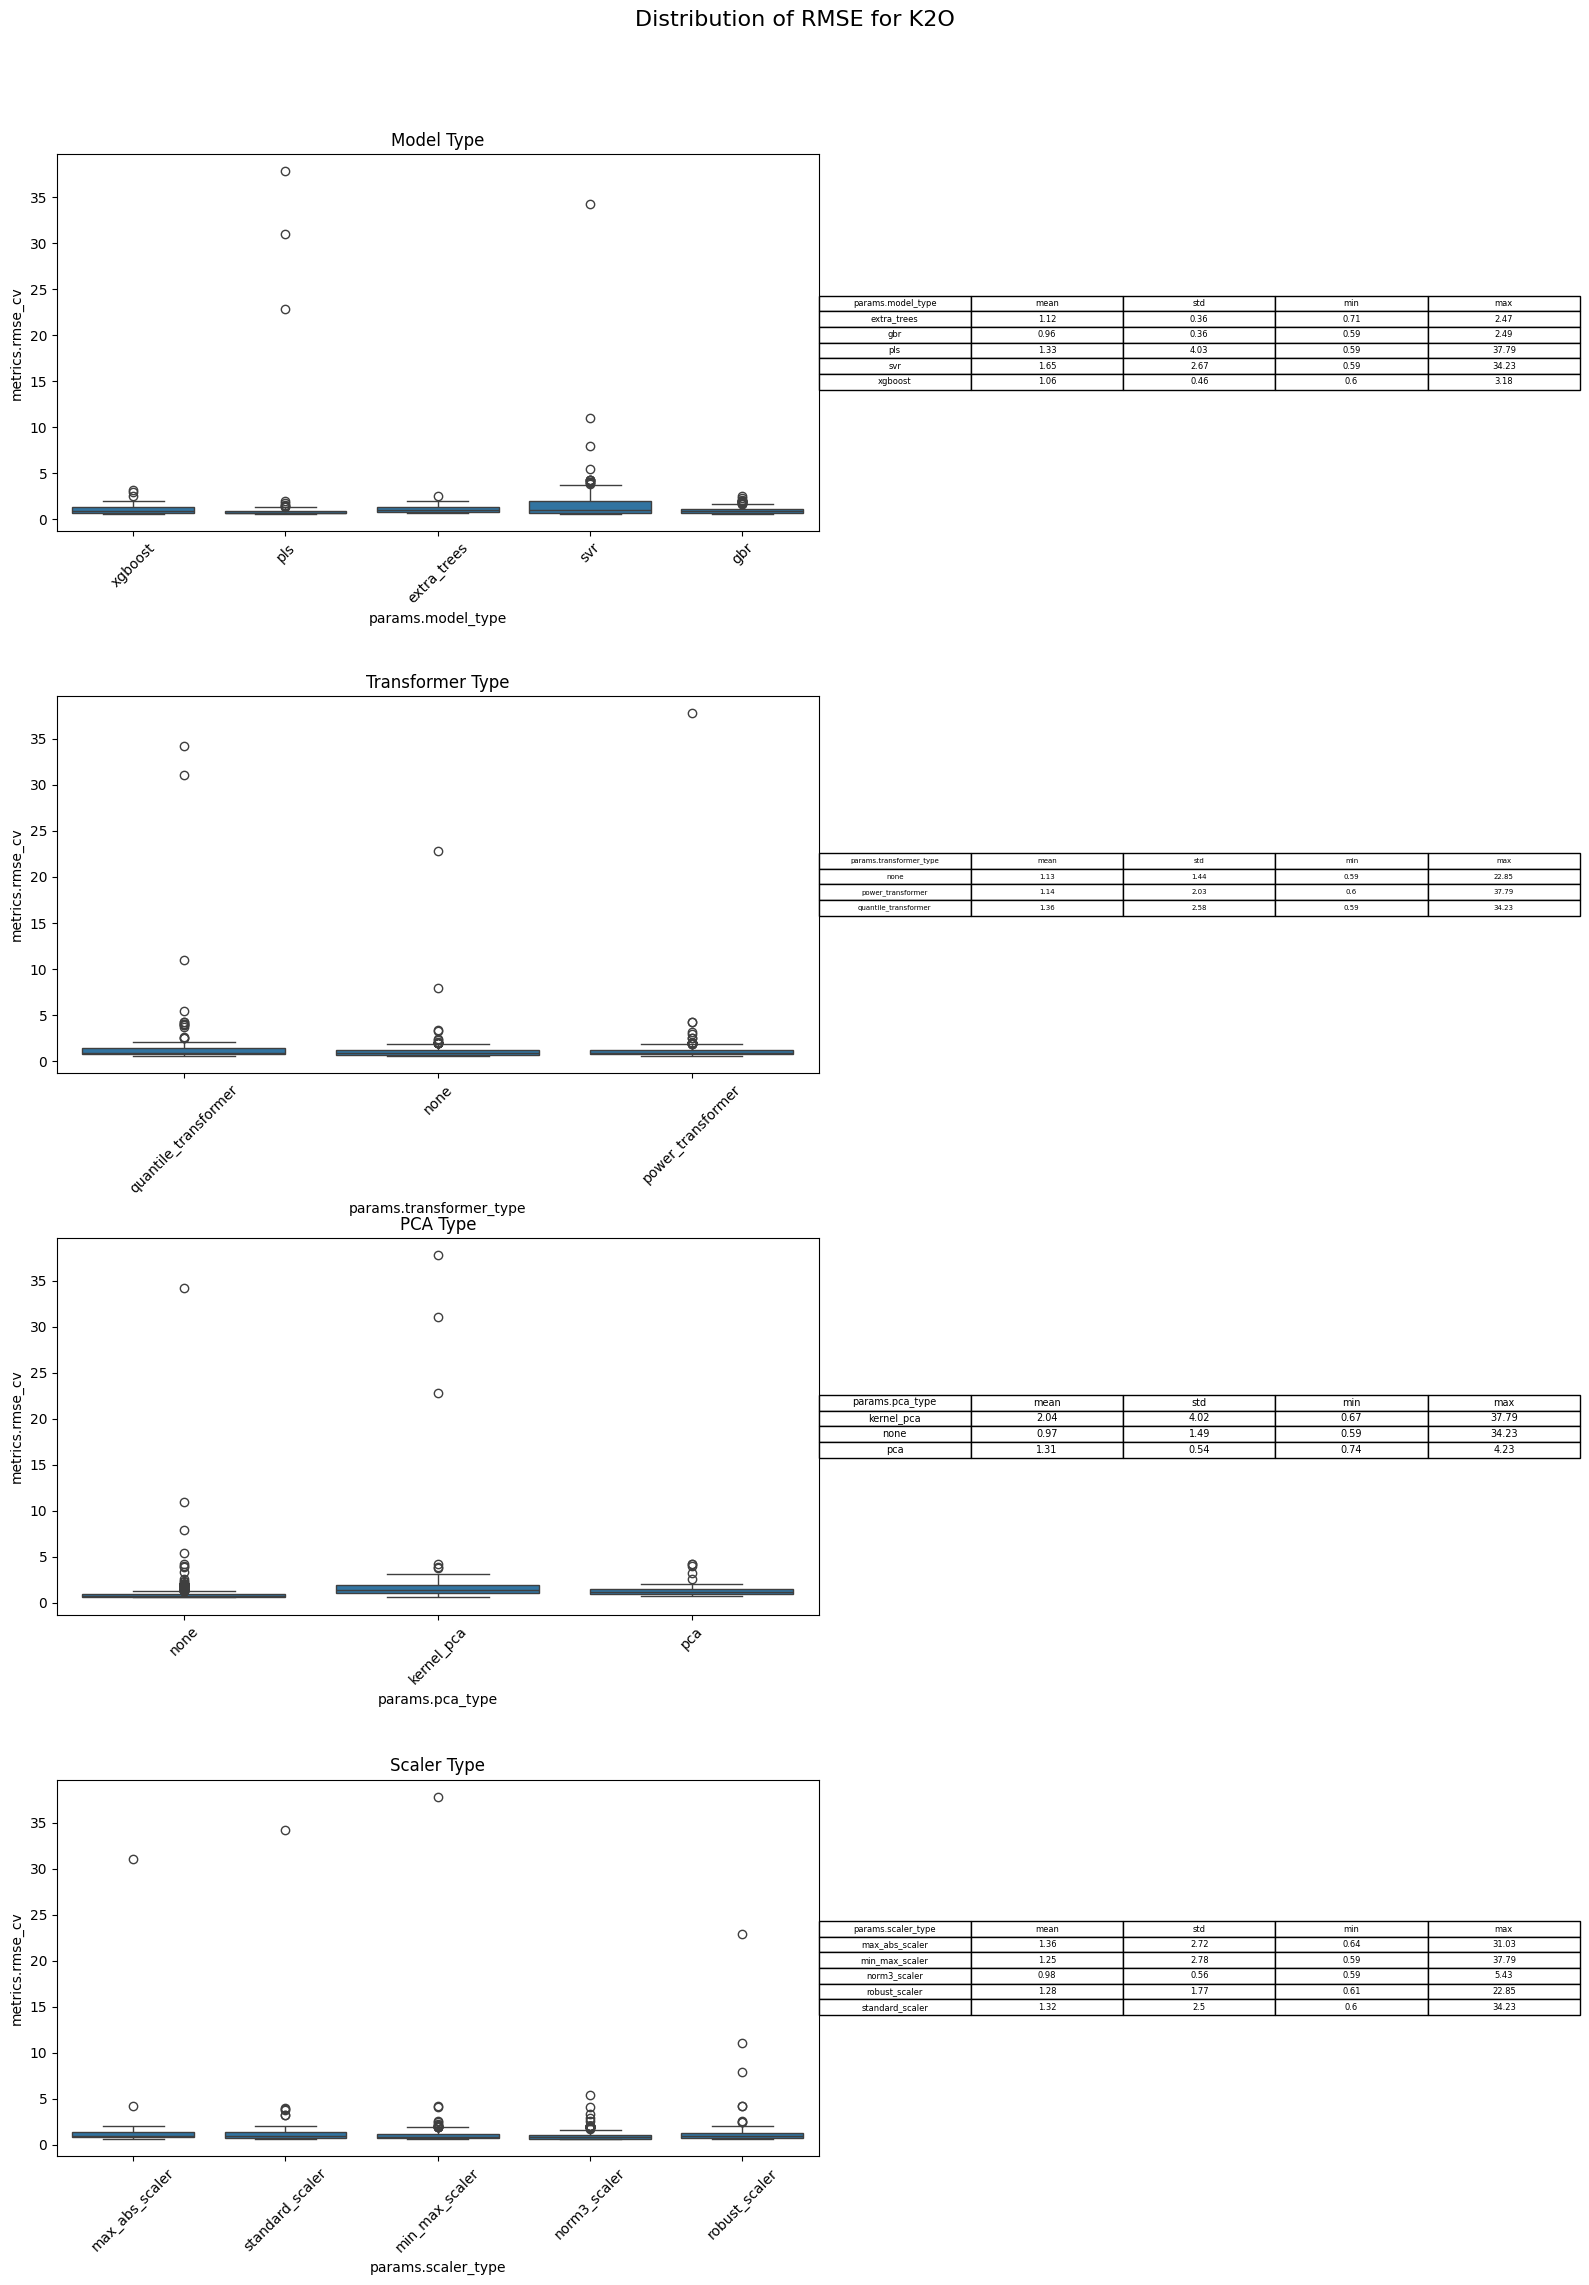

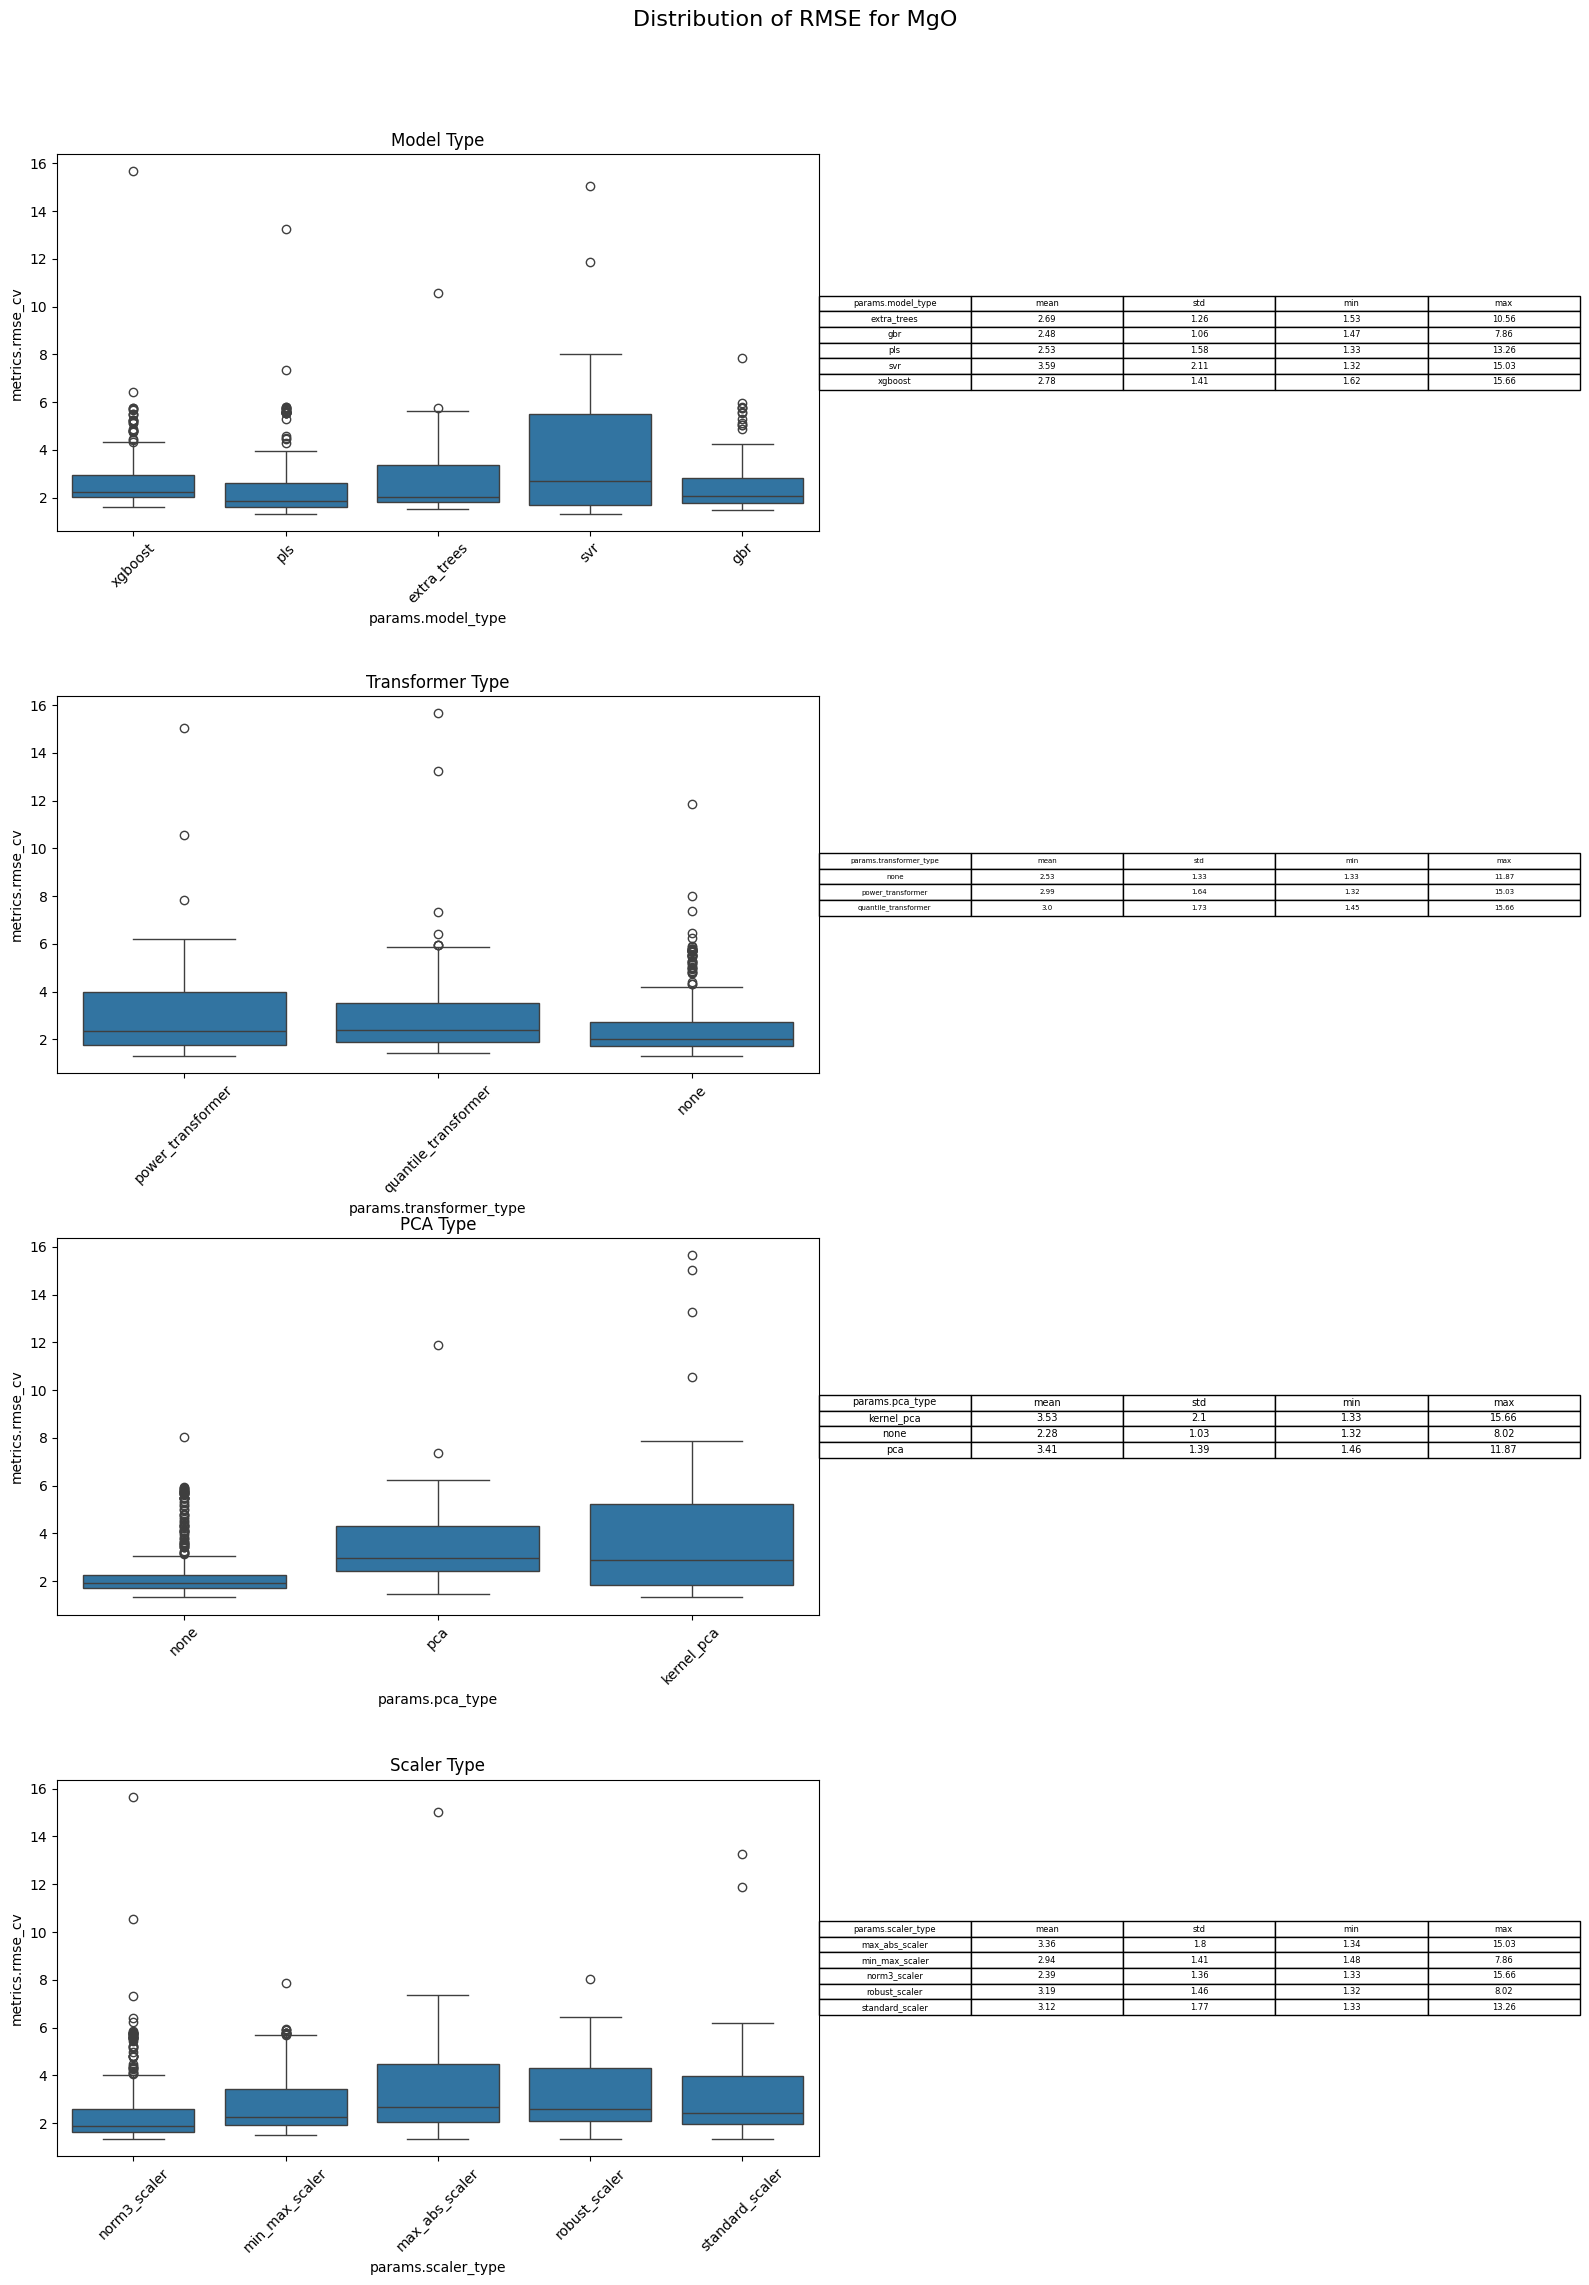

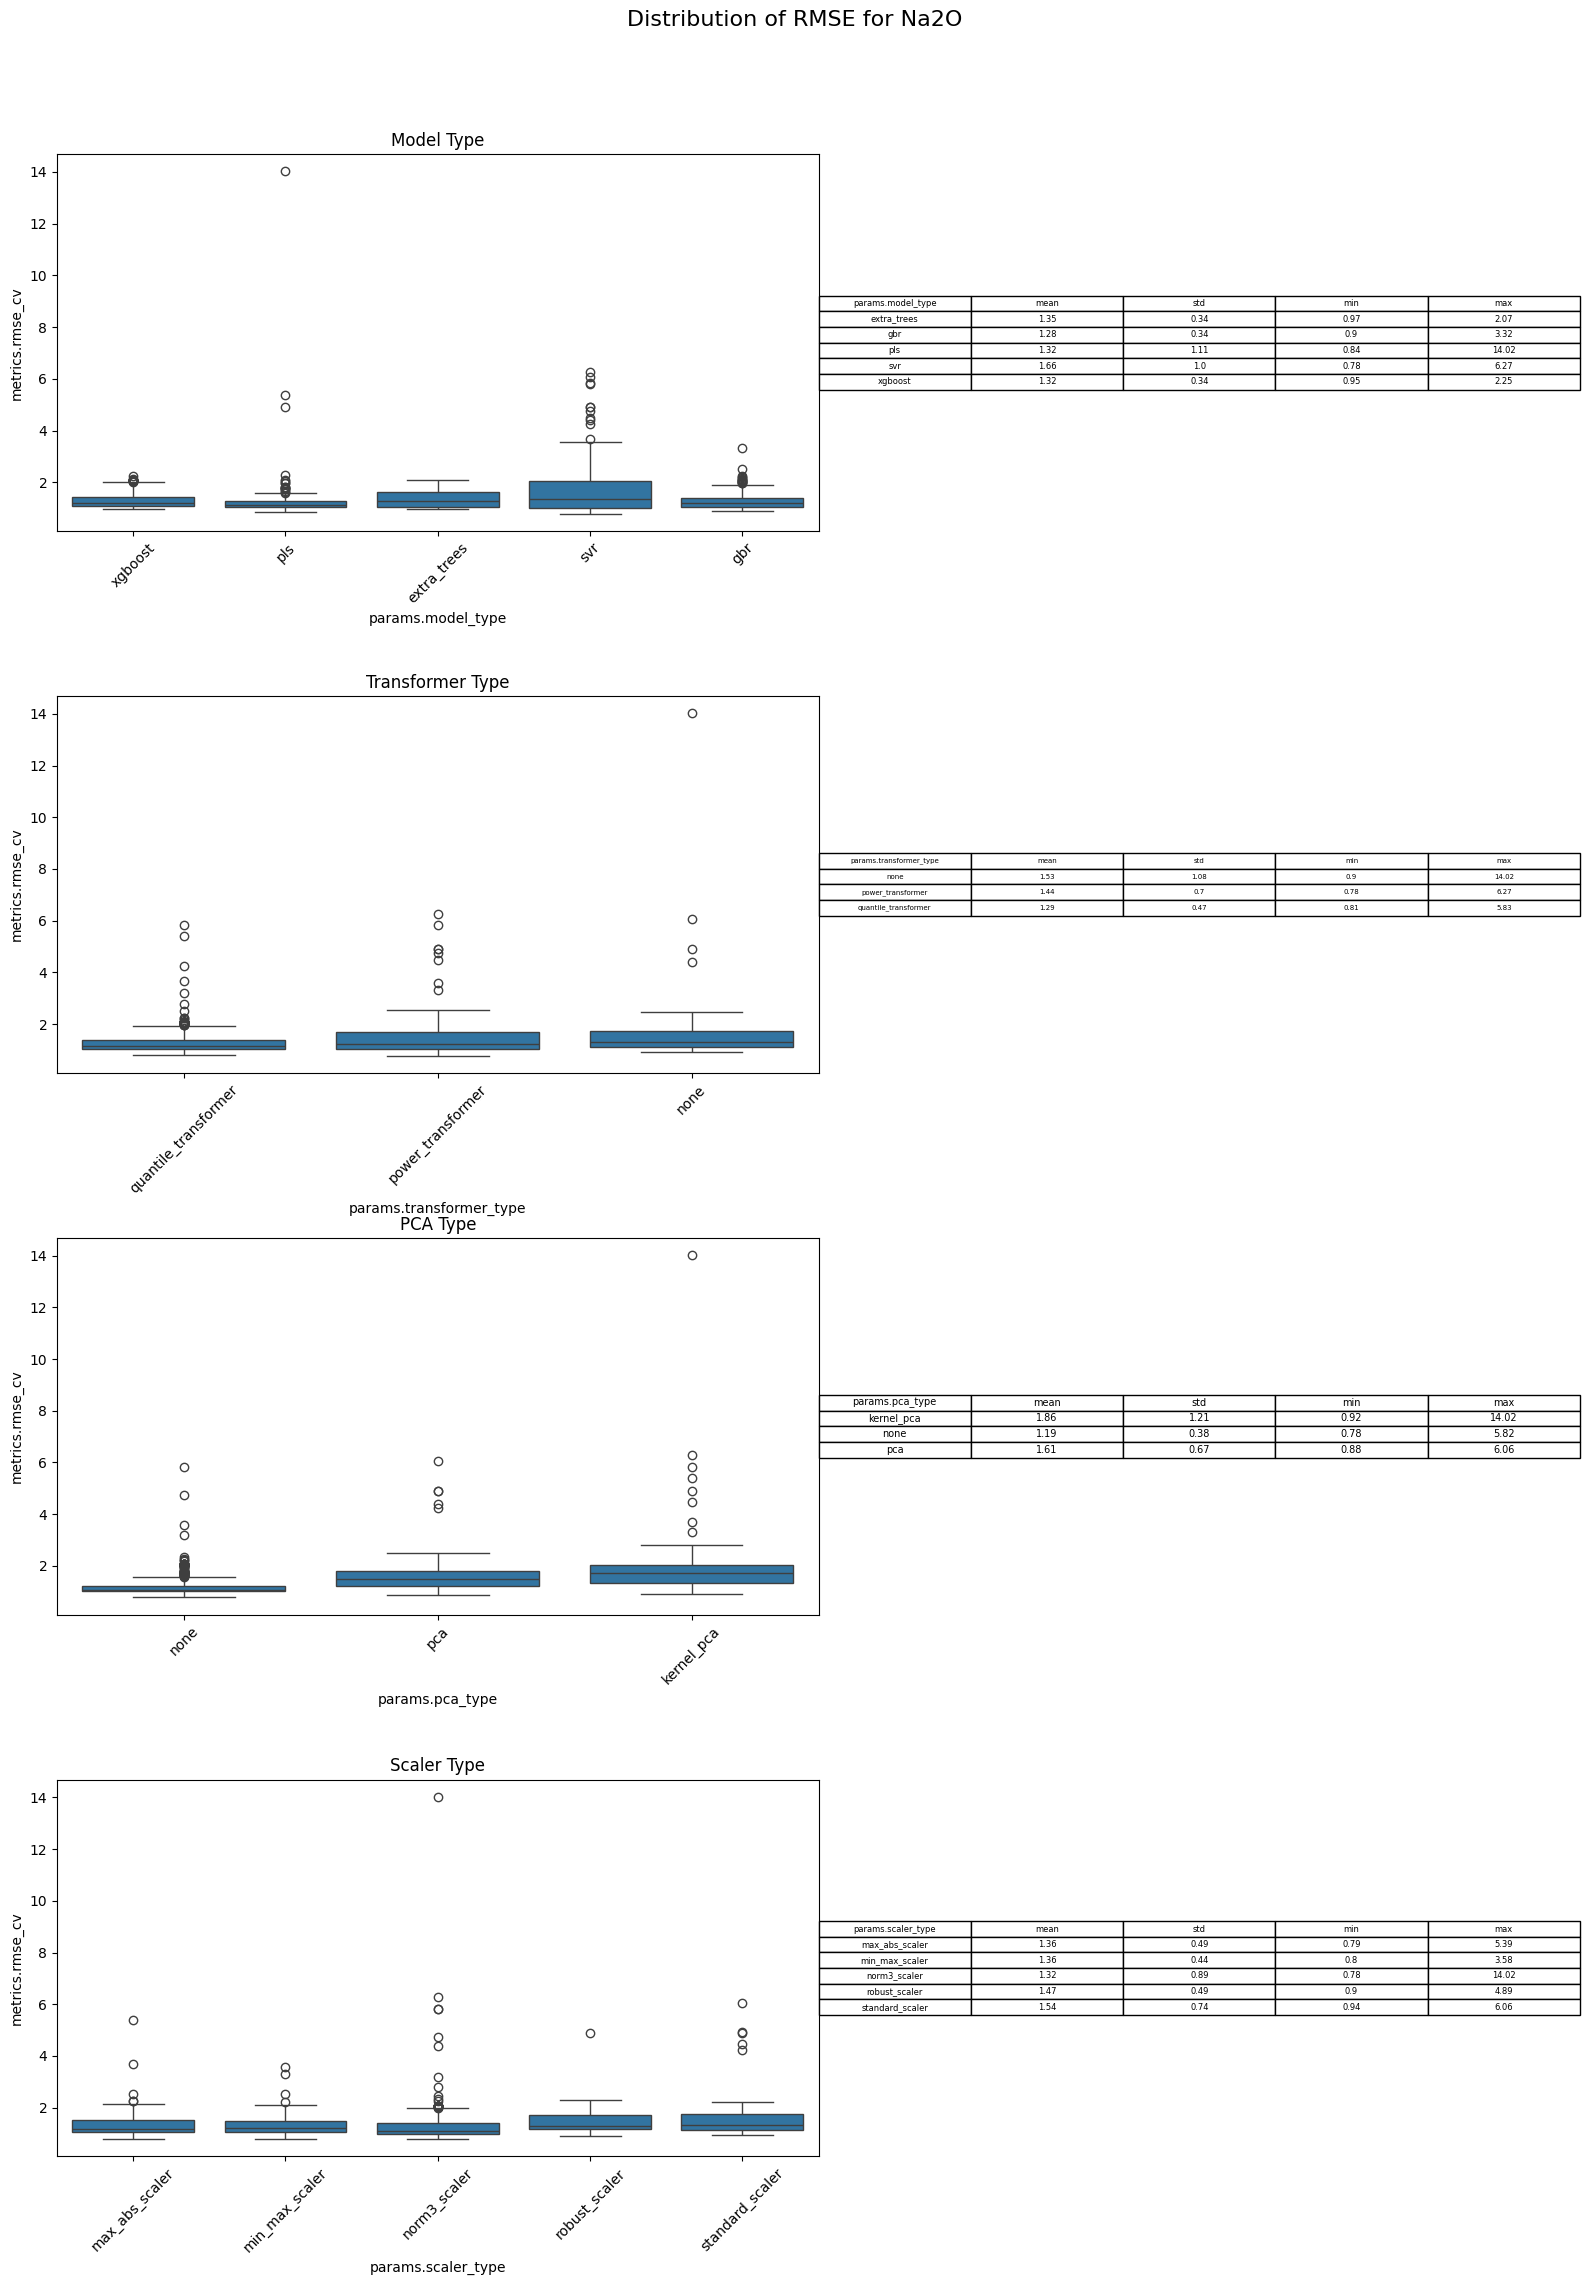

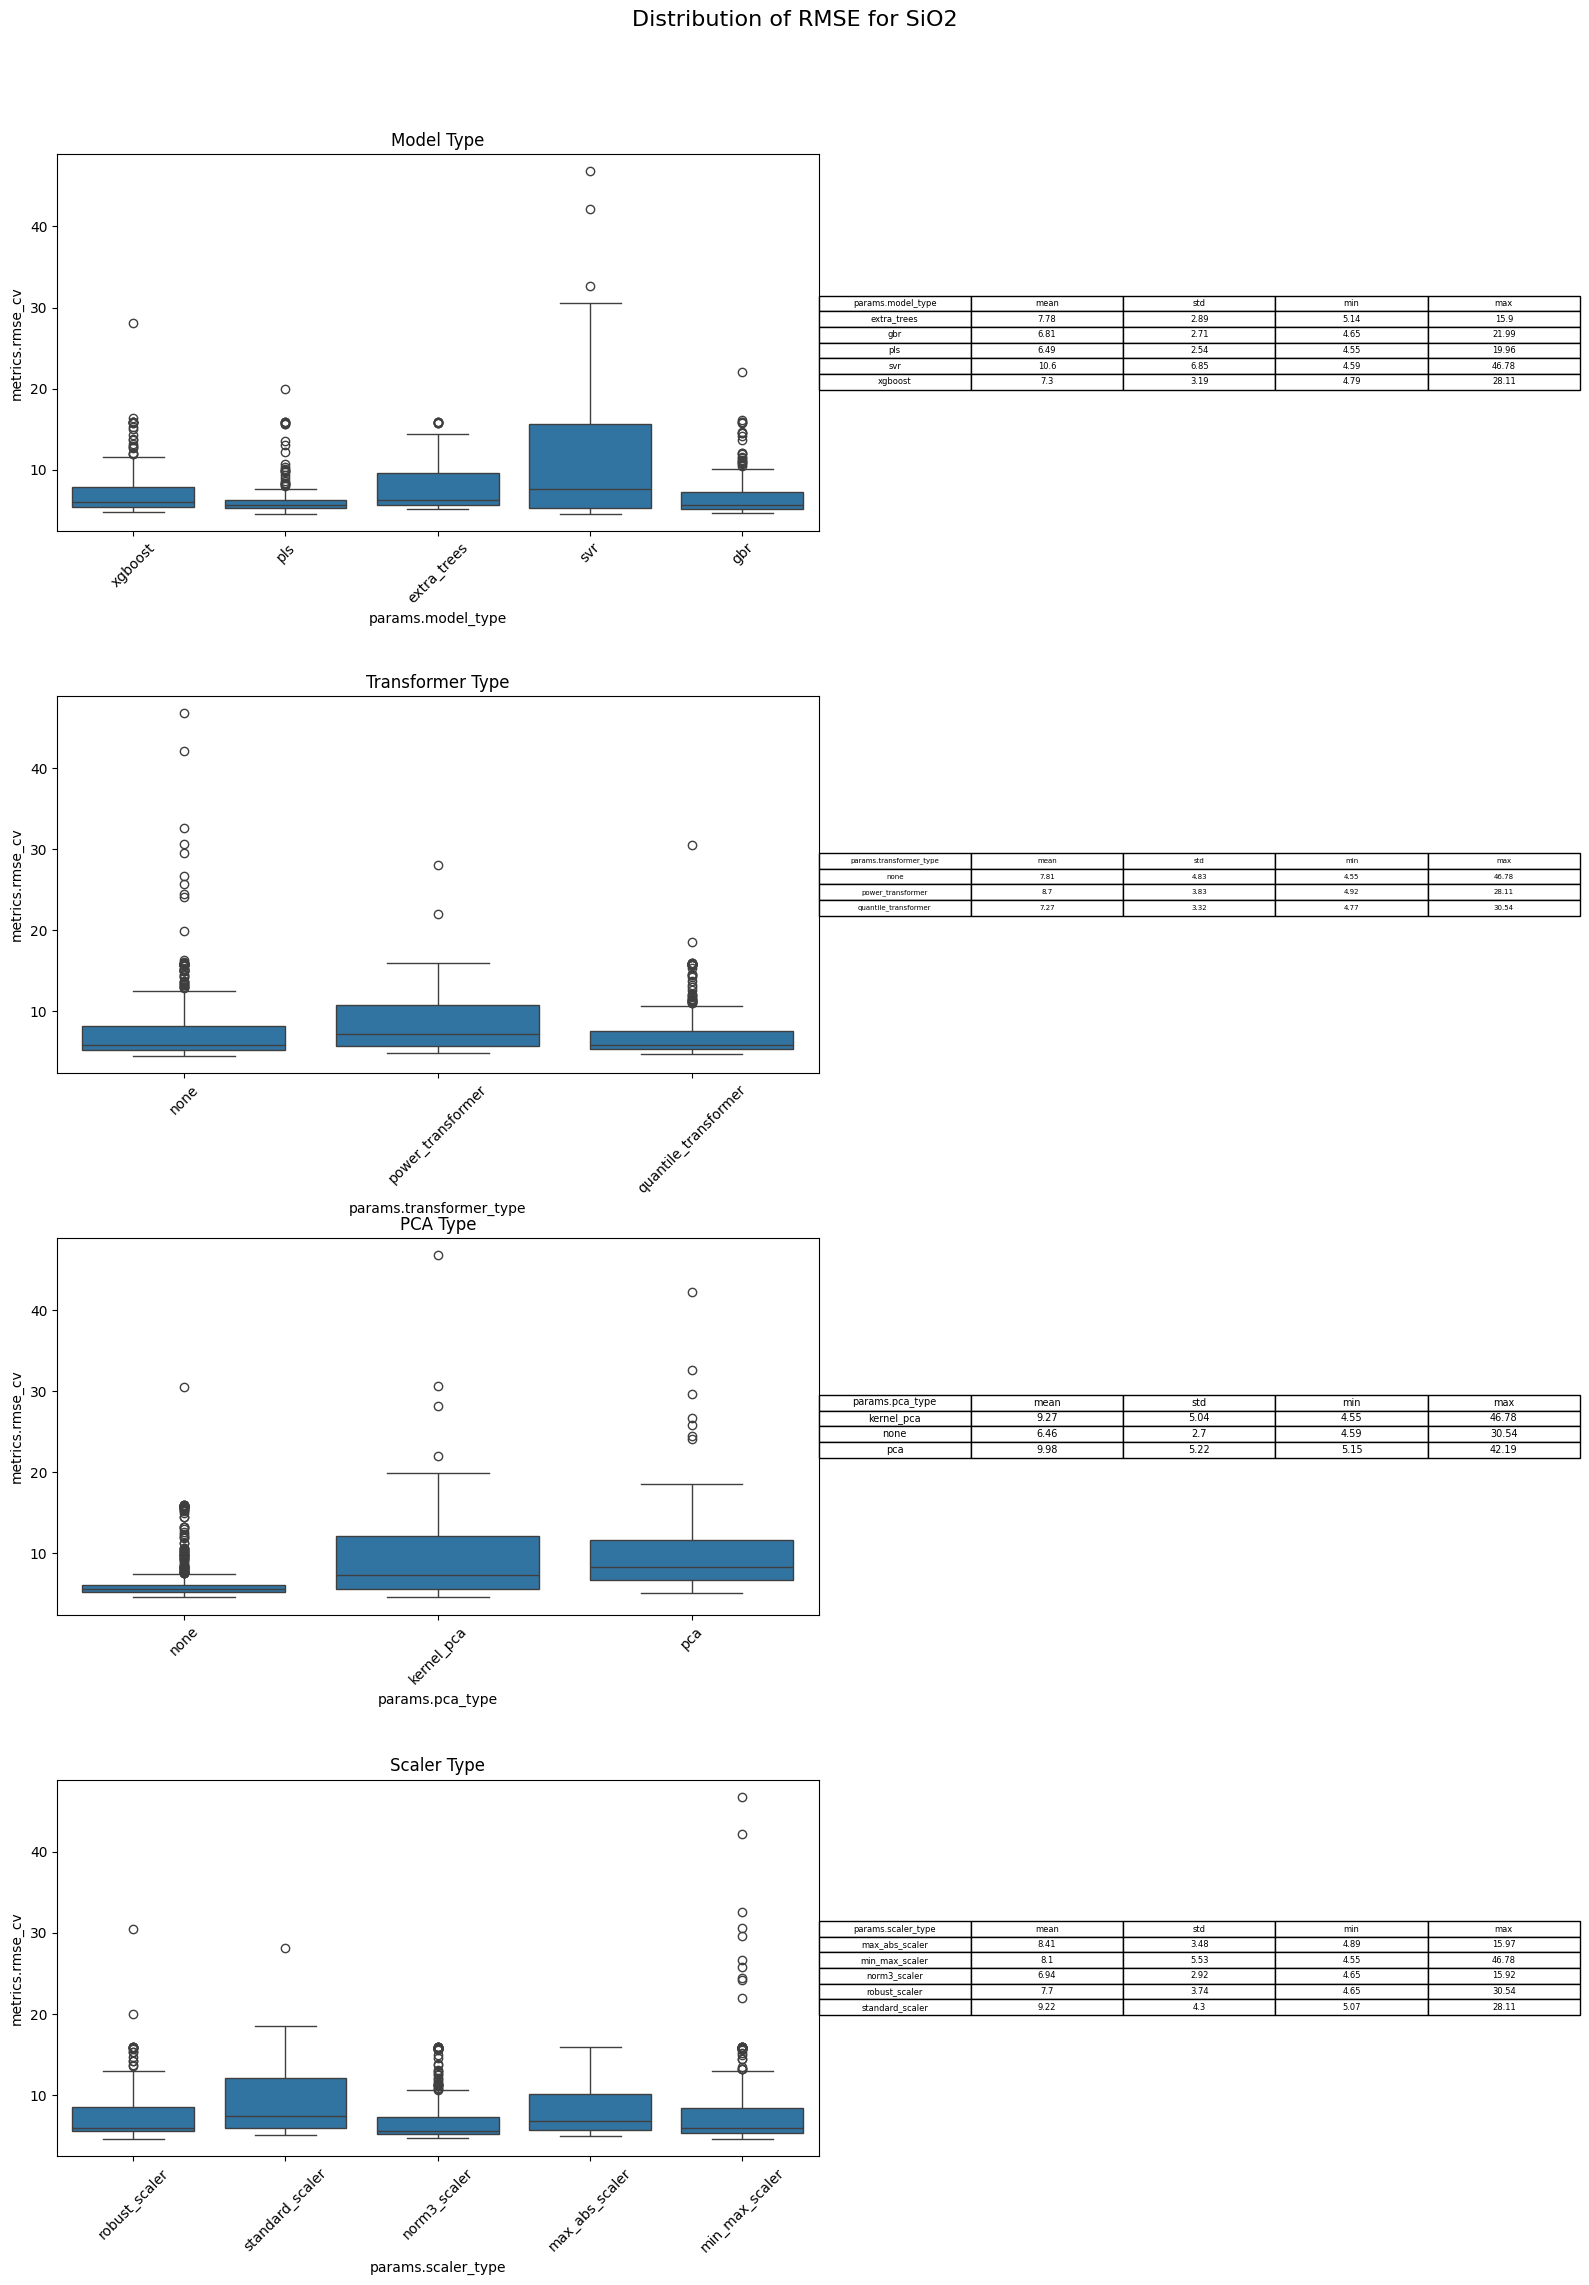

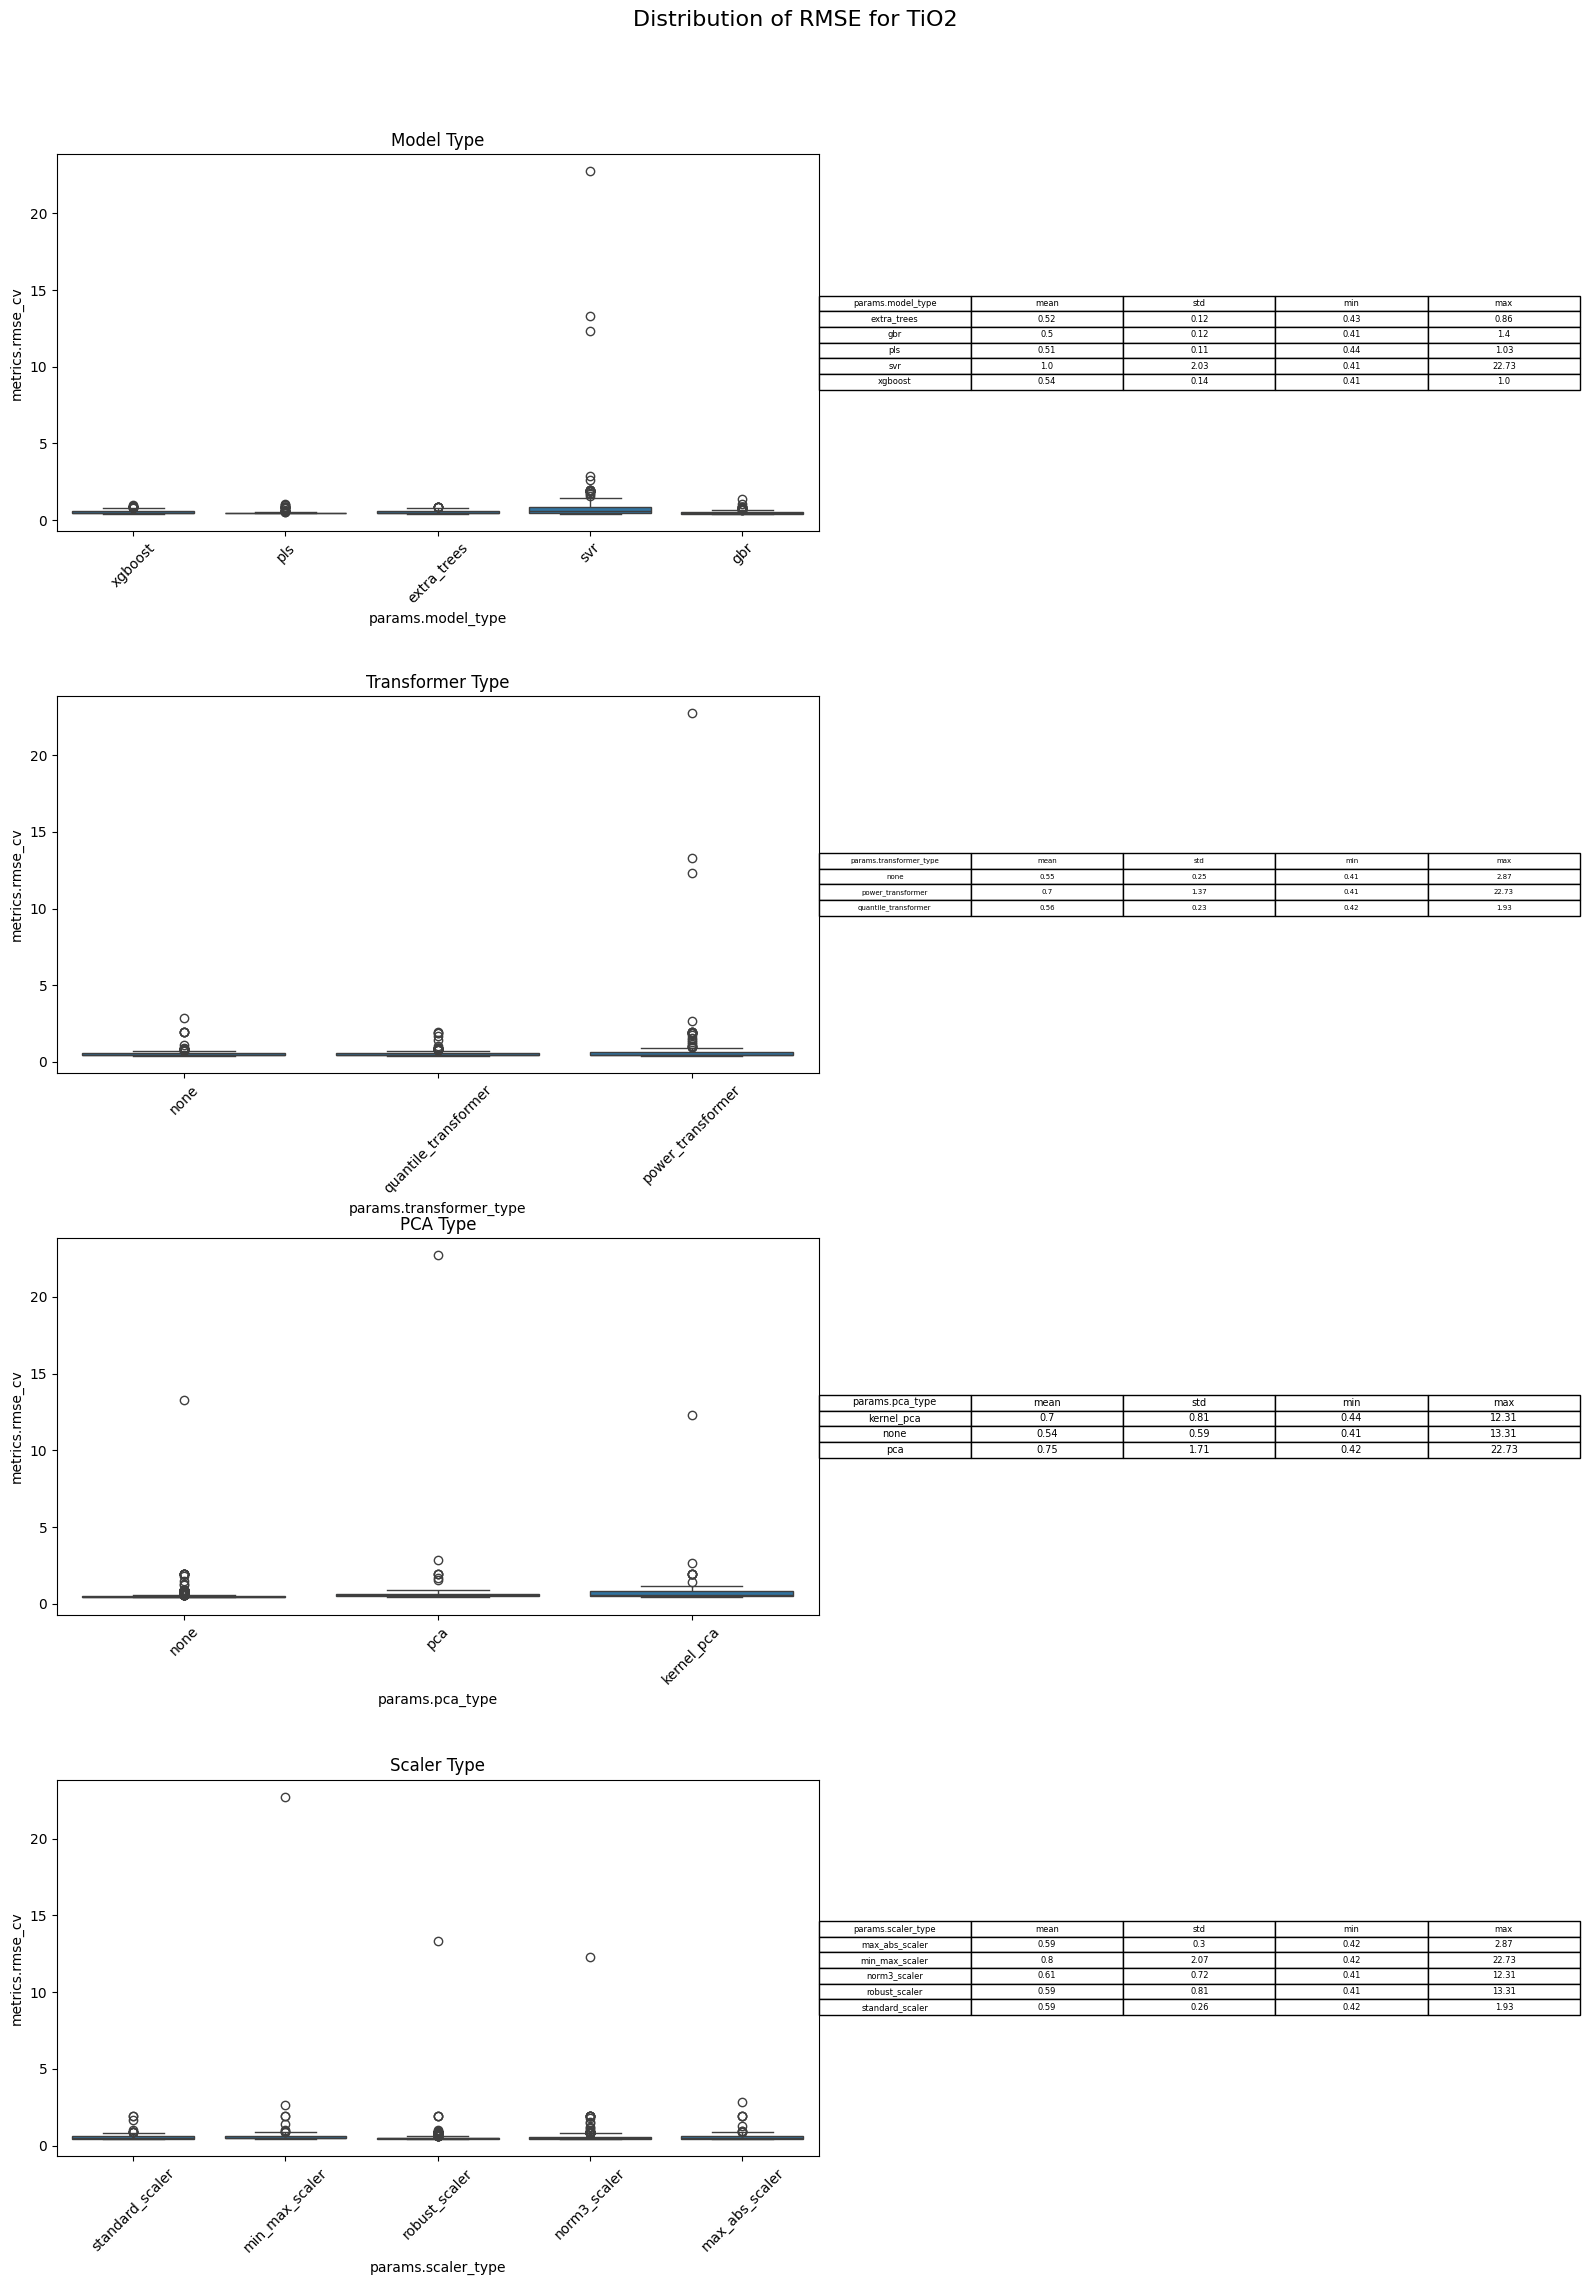

In [5]:
# Function to create box plots for each params.oxide
def create_box_plots(df):
    grouped = df.groupby('params.oxide')
    
    for oxide, group in grouped:
        plt.figure(figsize=(16, 24))  # Increased width from 16 to 24
        plt.suptitle(f'Distribution of RMSE for {oxide}', fontsize=16)

        # Box plot for params.model_type
        plt.subplot(4, 2, 1)
        sns.boxplot(x='params.model_type', y='metrics.rmse_cv', data=group)
        plt.title('Model Type')
        plt.xticks(rotation=45)
        
        plt.subplot(4, 2, 2)
        plt.axis('off')
        model_type_stats = group.groupby('params.model_type')['metrics.rmse_cv'].describe().reset_index()[['params.model_type', 'mean', 'std', 'min', 'max']]
        model_type_stats = model_type_stats.round(2)
        plt.table(cellText=model_type_stats.values, colLabels=model_type_stats.columns, cellLoc='center', loc='center')
        
        # Box plot for params.transformer_type
        plt.subplot(4, 2, 3)
        sns.boxplot(x='params.transformer_type', y='metrics.rmse_cv', data=group)
        plt.title('Transformer Type')
        plt.xticks(rotation=45)
        
        plt.subplot(4, 2, 4)
        plt.axis('off')
        transformer_type_stats = group.groupby('params.transformer_type')['metrics.rmse_cv'].describe().reset_index()[['params.transformer_type', 'mean', 'std', 'min', 'max']]
        transformer_type_stats = transformer_type_stats.round(2)
        plt.table(cellText=transformer_type_stats.values, colLabels=transformer_type_stats.columns, cellLoc='center', loc='center')

        # Box plot for params.pca_type
        plt.subplot(4, 2, 5)
        sns.boxplot(x='params.pca_type', y='metrics.rmse_cv', data=group)
        plt.title('PCA Type')
        plt.xticks(rotation=45)
        
        plt.subplot(4, 2, 6)
        plt.axis('off')
        pca_type_stats = group.groupby('params.pca_type')['metrics.rmse_cv'].describe().reset_index()[['params.pca_type', 'mean', 'std', 'min', 'max']]
        pca_type_stats = pca_type_stats.round(2)
        plt.table(cellText=pca_type_stats.values, colLabels=pca_type_stats.columns, cellLoc='center', loc='center')

        # Box plot for params.scaler_type
        plt.subplot(4, 2, 7)
        sns.boxplot(x='params.scaler_type', y='metrics.rmse_cv', data=group)
        plt.title('Scaler Type')
        plt.xticks(rotation=45)
        
        plt.subplot(4, 2, 8)
        plt.axis('off')
        scaler_type_stats = group.groupby('params.scaler_type')['metrics.rmse_cv'].describe().reset_index()[['params.scaler_type', 'mean', 'std', 'min', 'max']]
        scaler_type_stats = scaler_type_stats.round(2)
        plt.table(cellText=scaler_type_stats.values, colLabels=scaler_type_stats.columns, cellLoc='center', loc='center')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95], w_pad=0, h_pad=0)
        plt.show()

# Create box plots
create_box_plots(runs_filtered)

In [6]:
import pandas as pd
import scipy.stats as stats

# Function to perform Kruskal-Wallis H test
def analyze_correlations(df):
    results = []
    
    # Group by params.oxide
    grouped = df.groupby('params.oxide')
    
    for oxide, group in grouped:
        kw_results = {}
        for param in ['params.model_type', 'params.transformer_type', 'params.pca_type', 'params.scaler_type']:
            groups = [group['metrics.rmse_cv'][group[param] == level].values for level in group[param].unique()]
            if len(groups) > 1:  # Kruskal-Wallis test requires at least 2 groups
                stat, p_value = stats.kruskal(*groups)
                kw_results[param] = p_value
        
        # Identify the configuration with the lowest p-value
        best_param = min(kw_results, key=kw_results.get)
        results.append({
            'oxide': oxide,
            'best_param': best_param,
            'p_value': kw_results[best_param]
        })
    
    return pd.DataFrame(results)

# Load your data into df
# df = pd.read_csv('your_dataset.csv')

# Run the analysis
results_df = analyze_correlations(runs_filtered)


In [7]:
results_df

,oxide,best_param,p_value
0,Al2O3,params.pca_type,8.003079e-76
1,CaO,params.pca_type,7.594391e-90
2,FeO,params.pca_type,1.827105e-66
3,K2O,params.pca_type,1.190740e-74
4,MgO,params.pca_type,6.762019e-38
5,Na2O,params.pca_type,4.975005e-70
6,SiO2,params.pca_type,1.406295e-46
7,TiO2,params.pca_type,4.127962e-57


In [8]:
out = runs.groupby(['params.transformer_type', 'params.model_type', 'params.oxide']).size().reset_index(name='count')
pivot_table = out.pivot(index='params.oxide', columns=['params.transformer_type', 'params.model_type'], values='count')

# Add a total count for each transformer_type and oxide
out_total = runs.groupby(['params.transformer_type', 'params.oxide']).size().reset_index(name='total_count')
for transformer_type in out['params.transformer_type'].unique():
    pivot_table[(transformer_type, 'total_count')] = out_total[out_total['params.transformer_type'] == transformer_type].set_index('params.oxide')['total_count']

pivot_table

params.transformer_type        none                       power_transformer  \
params.model_type       extra_trees gbr  pls  svr xgboost       extra_trees   
params.oxide                                                                  
Al2O3                            55  34   31   37      38                93   
CaO                             111  84   39   33      37                52   
FeO                             117  43   29   36      99                45   
K2O                              39  55  113   36      40               122   
MgO                              46  80  111   37     107               106   
Na2O                             38  58   29   36      37                43   
SiO2                            103  82  115  129      38                48   
TiO2                             79  48   29   37     107                88   

params.transformer_type                        quantile_transformer            \
params.model_type        gbr  pls  svr xgboost          extra_trees  gbr  pls   
params.oxide                                                                    
Al2O3                     53   31   40     108                   49  110  115   
CaO                       36   33   59     125                   36   80  102   
FeO                      116  108   41      43                   38   38   35   
K2O                       37   32   40     119                   39  108   30   
MgO                       37   32  123      53                   47   81   33   
Na2O                      40   48  122      41                  118   99   98   
SiO2                      34   31   37      39                   49   83   31   
TiO2                      76  112  124      42                   32   74   32   

params.transformer_type                     none power_transformer  \
params.model_type        svr xgboost total_count       total_count   
params.oxide                                                         
Al2O3                    121      52         195               325   
CaO                      105      38         304               305   
FeO                      122      57         324               353   
K2O                      121      41         283               350   
MgO                       35      39         381               351   
Na2O                      39     121         198               294   
SiO2                      34     122         467               189   
TiO2                      38      50         300               442   

params.transformer_type quantile_transformer  
params.model_type                total_count  
params.oxide                                  
Al2O3                                    447  
CaO                                      361  
FeO                                      290  
K2O                                      339  
MgO                                      235  
Na2O                                     475  
SiO2                                     319  
TiO2                                     226

In [9]:
# Define a threshold to filter out the extremely high RMSE values as outliers
threshold = 15

# Filter out rows with NaN values in 'params.transformer_type' and 'params.model_type'
filtered_data = runs.dropna(subset=['params.transformer_type', 'params.model_type'])

# Filter the data to remove outliers
filtered_data = filtered_data[filtered_data['metrics.rmse_cv'] < threshold]

# Calculate the mean RMSE for each combination of transformer type, model type, and oxide using 'metrics.rmse_cv'
mean_rmse_cv = filtered_data.groupby(['params.transformer_type', 'params.model_type', 'params.oxide'])['metrics.rmse_cv'].mean().reset_index()

# Calculate the overall mean RMSE for each combination of transformer type and model type using 'metrics.rmse_cv'
overall_mean_rmse_cv = filtered_data.groupby(['params.transformer_type', 'params.model_type'])['metrics.rmse_cv'].mean().reset_index()

mean_rmse_cv


,params.transformer_type,params.model_type,params.oxide,metrics.rmse_cv
0,none,extra_trees,Al2O3,3.638742
1,none,extra_trees,CaO,2.475120
2,none,extra_trees,FeO,4.036212
3,none,extra_trees,K2O,1.220311
4,none,extra_trees,MgO,2.782244
...,...,...,...,...
115,quantile_transformer,xgboost,K2O,1.108091
116,quantile_transformer,xgboost,MgO,2.961538
117,quantile_transformer,xgboost,Na2O,1.284493
118,quantile_transformer,xgboost,SiO2,6.641999


In [10]:
overall_mean_rmse_cv

,params.transformer_type,params.model_type,metrics.rmse_cv
0,none,extra_trees,3.332615
1,none,gbr,2.739534
2,none,pls,2.758659
3,none,svr,4.419211
4,none,xgboost,2.564033
5,power_transformer,extra_trees,2.706182
6,power_transformer,gbr,2.819086
7,power_transformer,pls,2.284332
8,power_transformer,svr,2.687348
9,power_transformer,xgboost,2.500394


In [11]:
overall_mean_rmse_cv.groupby(['params.transformer_type'])['metrics.rmse_cv'].mean().reset_index()

,params.transformer_type,metrics.rmse_cv
0,none,3.162810
1,power_transformer,2.599468
2,quantile_transformer,2.769887


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group and pivot the data
teste = mean_rmse_cv.groupby(['params.transformer_type', 'params.oxide'])['metrics.rmse_cv'].mean().reset_index()
pivot_table = teste.pivot(index='params.oxide', columns='params.transformer_type', values='metrics.rmse_cv')
pivot_table

params.transformer_type,none,power_transformer,quantile_transformer
params.oxide,,,
Al2O3,3.908316,3.684949,3.133337
CaO,2.850825,2.503175,3.002609
FeO,4.231012,4.298604,3.924646
K2O,1.163087,1.017511,1.126604
MgO,2.822701,2.956451,3.095864
Na2O,1.584646,1.398808,1.341690
SiO2,6.691752,7.731626,6.696896
TiO2,0.576560,0.620198,0.573264


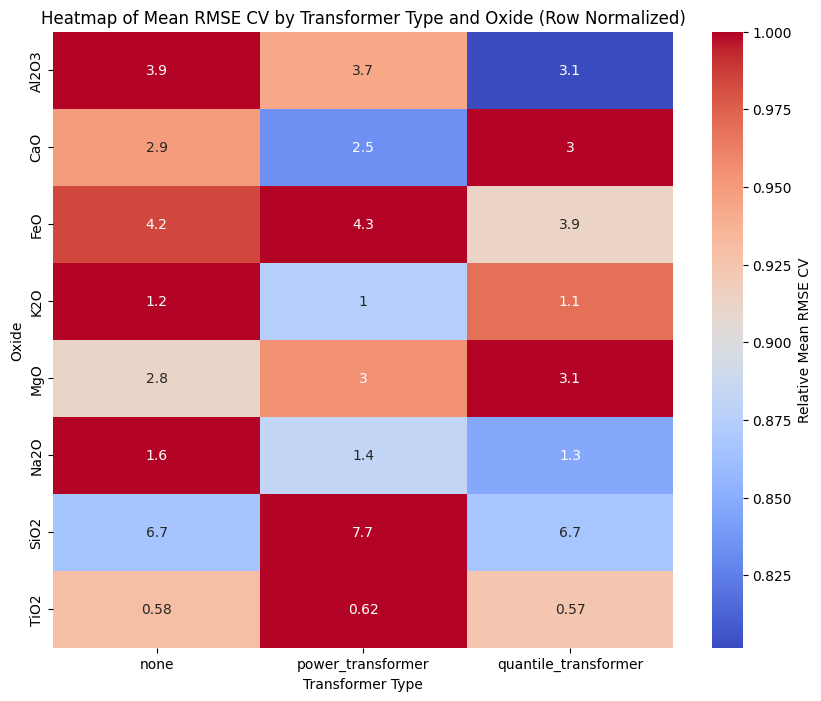

In [13]:
# Normalize the data by row
pivot_table_normalized = pivot_table.div(pivot_table.max(axis=1), axis=0)

# Plot the heatmap with a more visually comfortable color palette
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table_normalized, annot=pivot_table, cmap='coolwarm', cbar_kws={'label': 'Relative Mean RMSE CV'})
plt.title('Heatmap of Mean RMSE CV by Transformer Type and Oxide (Row Normalized)')
plt.xlabel('Transformer Type')
plt.ylabel('Oxide')
plt.show()


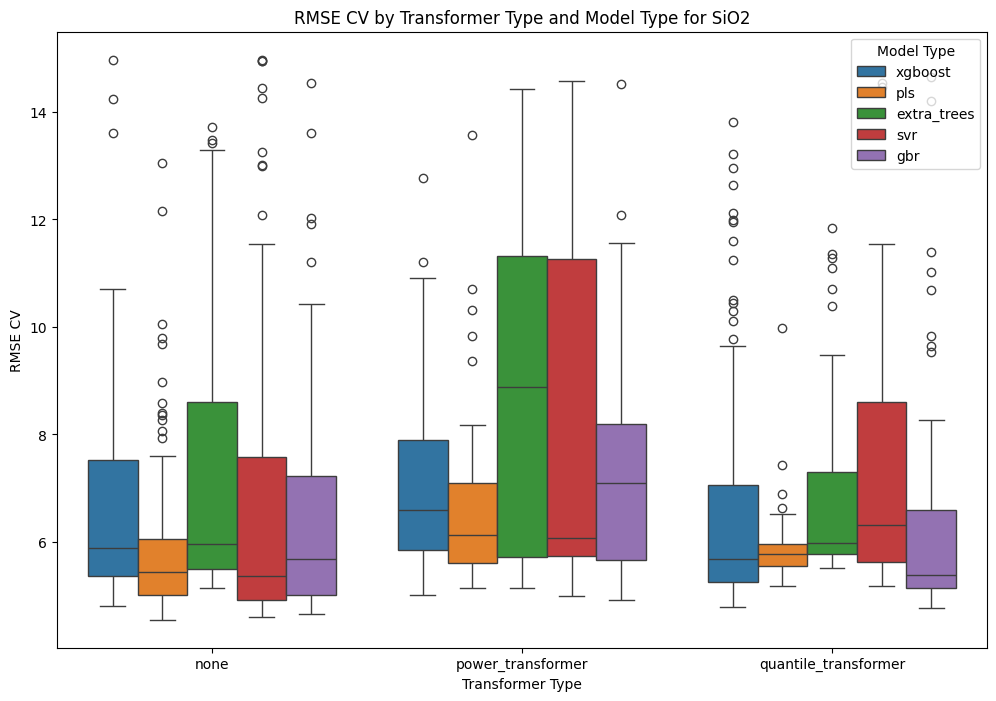

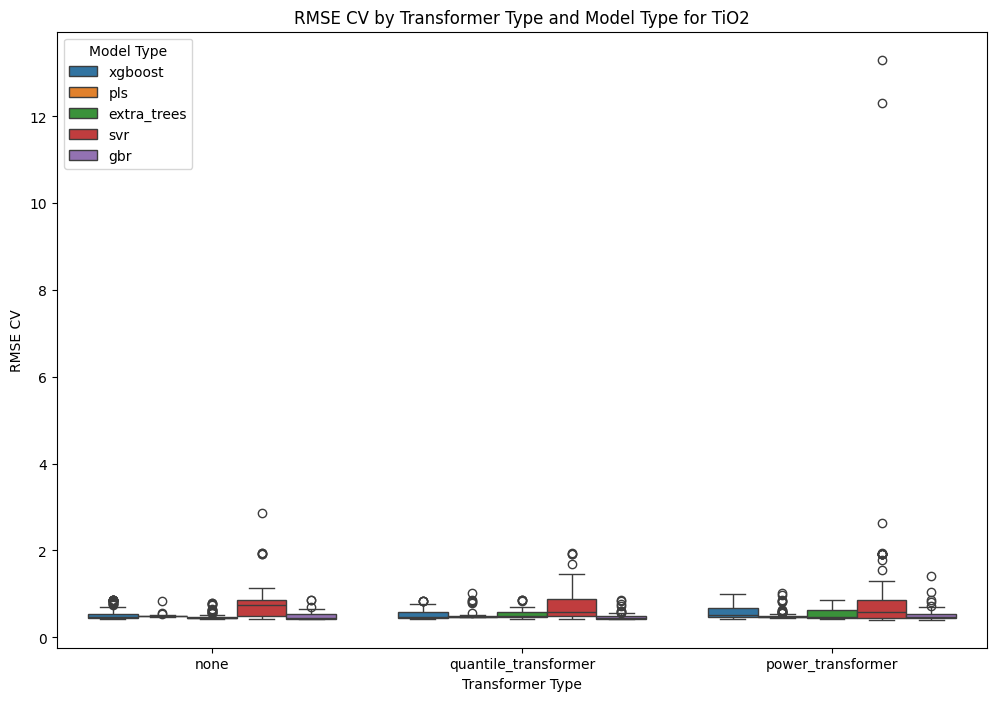

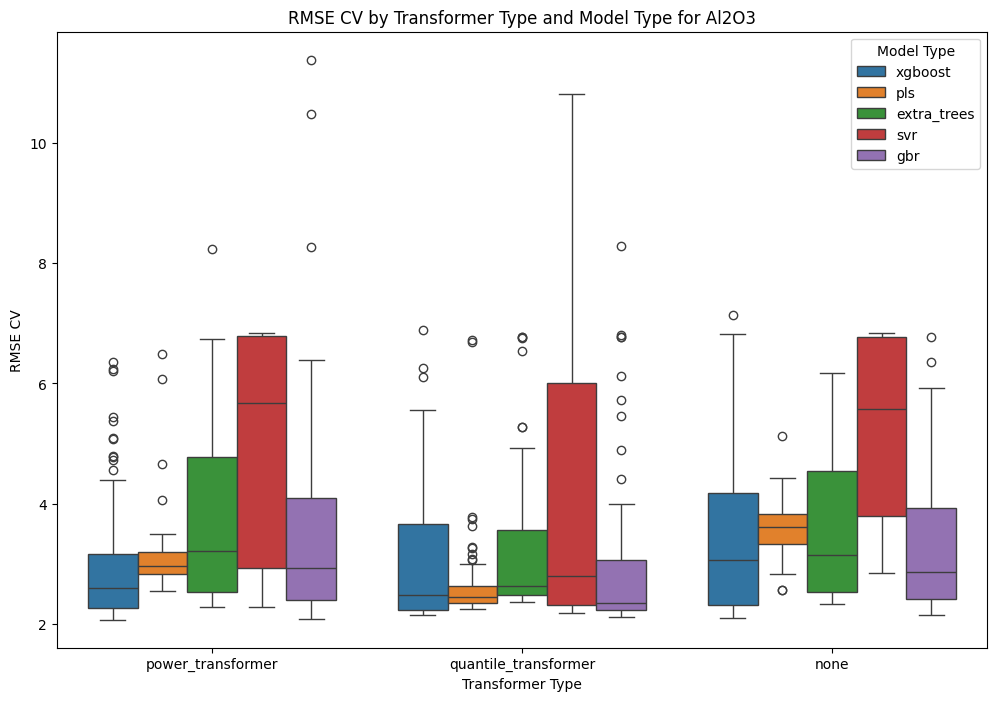

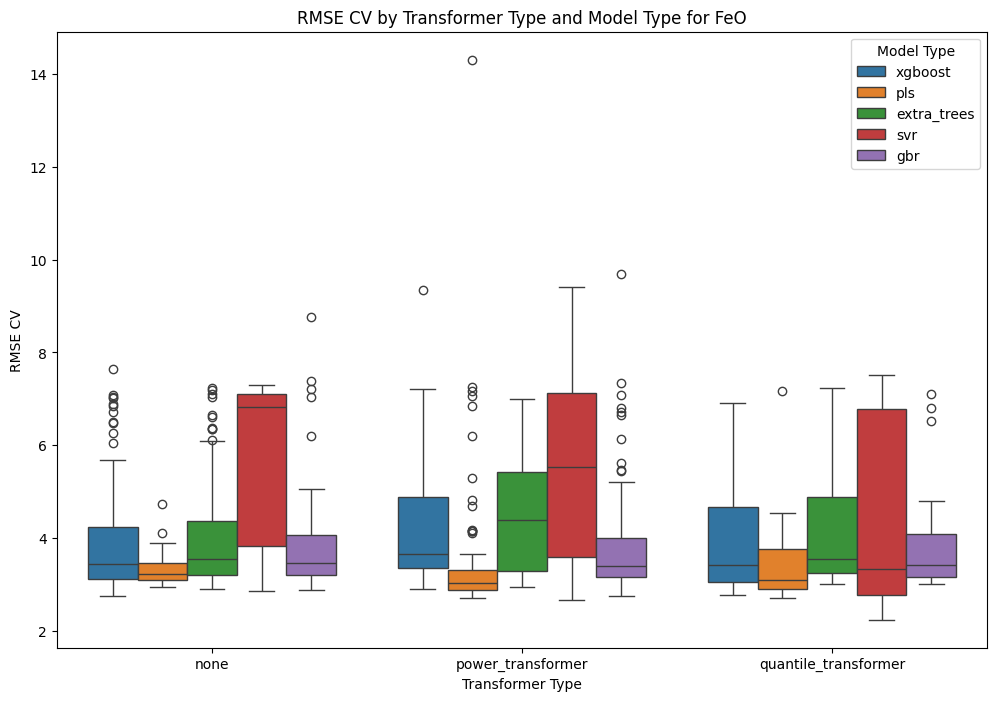

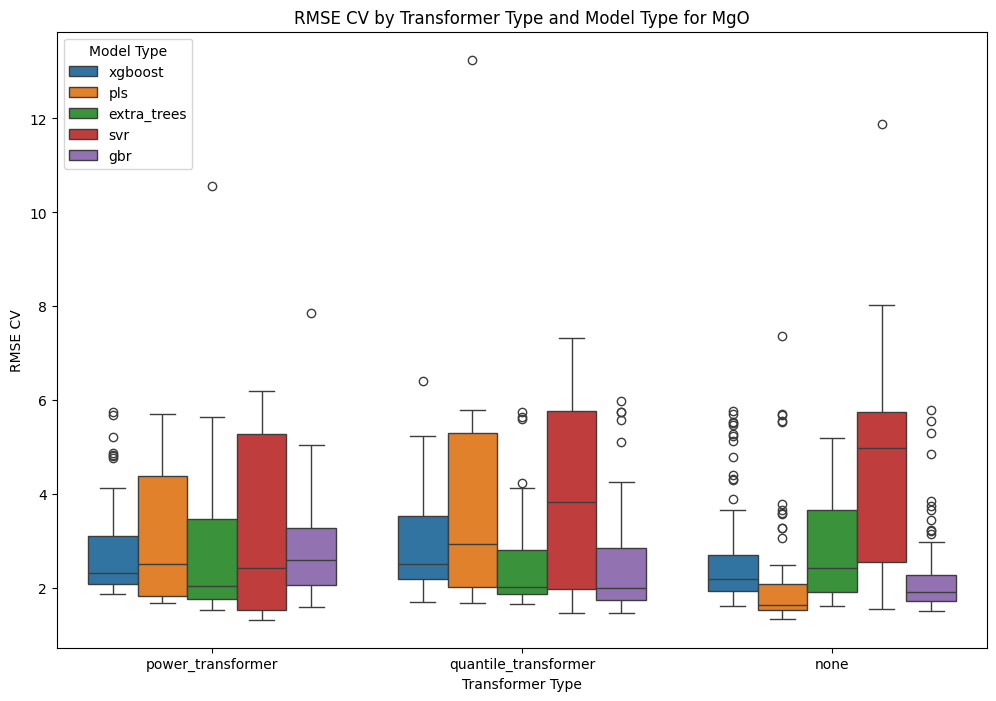

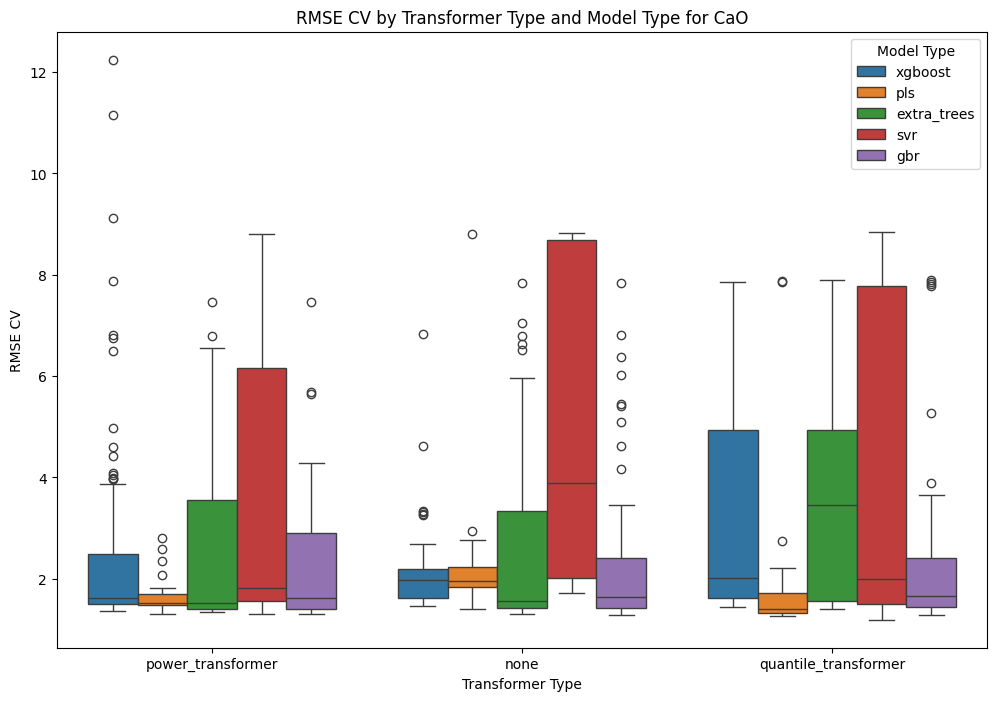

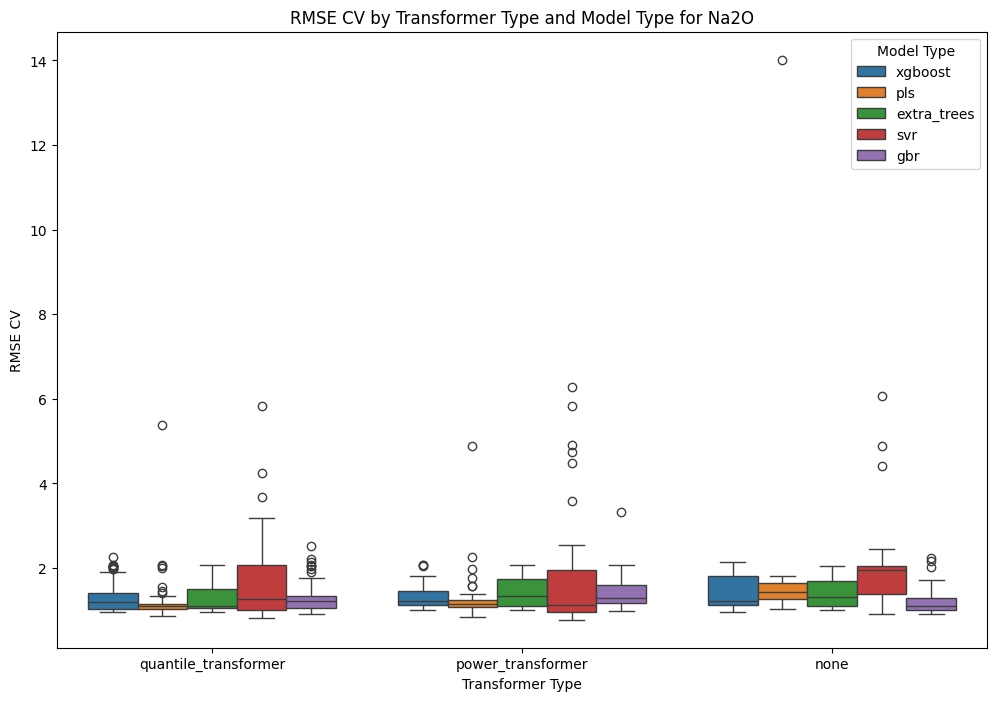

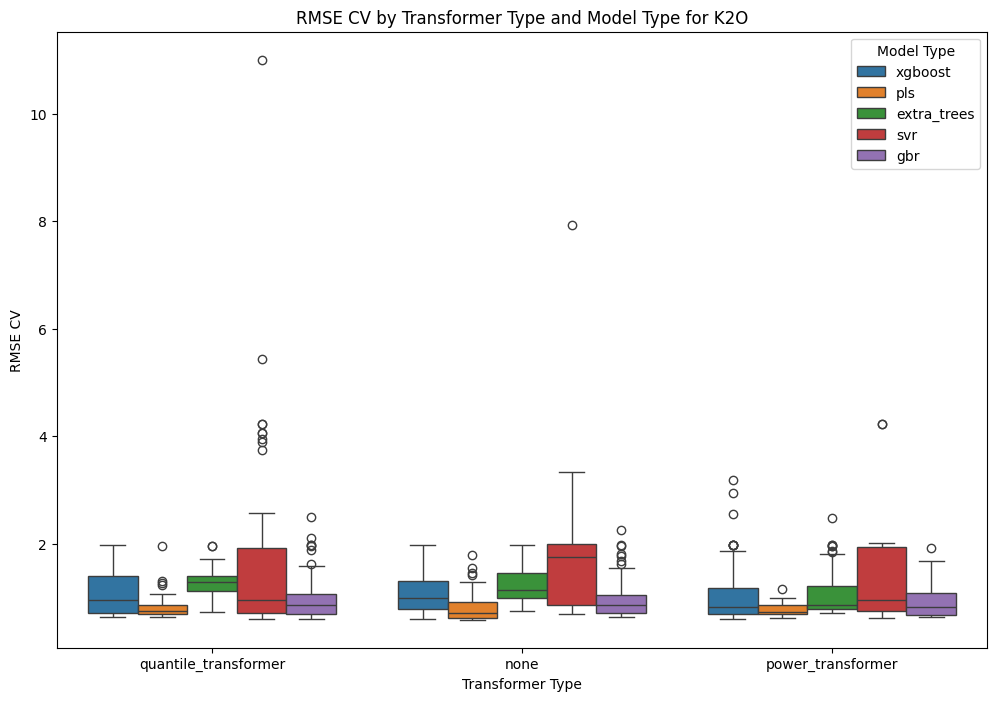

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot for overall RMSE CV by transformer type and model type for each oxide
oxides = filtered_data['params.oxide'].unique()

for oxide in oxides:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='params.transformer_type', y='metrics.rmse_cv', hue='params.model_type', data=filtered_data[filtered_data['params.oxide'] == oxide])
    plt.title(f'RMSE CV by Transformer Type and Model Type for {oxide}')
    plt.xlabel('Transformer Type')
    plt.ylabel('RMSE CV')
    plt.legend(title='Model Type')
    plt.show()


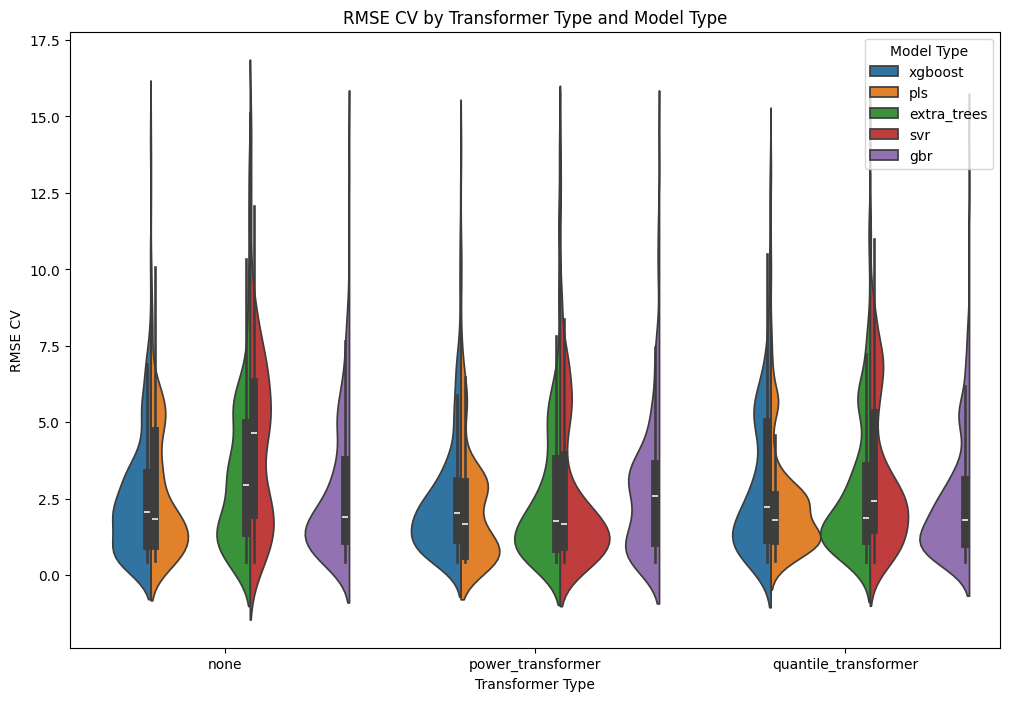

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.figure(figsize=(12, 8))

# Create a violin plot for overall RMSE CV by transformer type and model type
sns.violinplot(x='params.transformer_type', y='metrics.rmse_cv', hue='params.model_type', data=filtered_data, split=True)

# Title and labels
plt.title('RMSE CV by Transformer Type and Model Type')
plt.xlabel('Transformer Type')
plt.ylabel('RMSE CV')

# Show the plot
plt.legend(title='Model Type')
plt.show()

